# Compute the MDS plot after having computed the dissimilarity matrices (see `compute_dsmroi_firstlev.py` script)

In [1]:
%matplotlib inline
#import matplotlib
#matplotlib.use('svg')
#import matplotlib.pyplot as plt

In [2]:
import sys
p = ['../', '/home/contematto/github/seaborn/']
for pp in p:
    if pp not in sys.path:
        sys.path.insert(1, pp)

In [3]:
import expdir
from mds_rois import bootstrap_mds, get_dsm_roi_xval1, dendrogram_dss_mvdoc, xboost, mdsf, \
                     plot_dsm, select_rois_pymvpa, get_minmax, mk_colorbar
from numpy.ma import masked_array
from mvpa2.suite import *
fns = expdir.expdir()
from scipy.spatial import distance as dist
from scipy.stats import scoreatpercentile
from matplotlib import cm
import mne

In [4]:
from os.path import join as pjoin

In [5]:
def load_dsm(subnr):
    fn = pjoin(fns.mvpadir(subnr), 'roi_rsa_jimroi_5r_fisher_nooverlap/dsm_condition.hdf5')
    ds = h5load(fn)
    return ds

In [6]:
def make_ds_distance(ds, make_symmetric=False, rank=False):
    if rank:
        ds_ = np.apply_along_axis(rankdata, 1, ds)
    else:
        ds_ = ds.samples
    if make_symmetric:
        # add transpose and take only upper triangular with diagonal
        ds_new = []
        for row in ds_:
            tmp = row.reshape(8, 8)
            tmp += tmp.T
            tmp /= 2
            ds_new.append(tmp[np.triu_indices_from(tmp)])
        ds_ = np.array(ds_new)
        
    ds_dist = squareform(pdist(ds_, metric='correlation'))
    return Dataset(ds_dist, sa=ds.sa, fa={'roi': ds.sa.targets})

In [7]:
# this contains the first level
roi_rdm = [load_dsm(i) for i in range(1, 34)]
# this contains the second level for each subject
roi_dist = [make_ds_distance(ds, make_symmetric=True) for ds in roi_rdm]
#roi_dist = [make_ds_distance(ds, rank=True) for ds in roi_rdm]

In [8]:
# save second level
save = True
if save:
    h5save('taskdata_rdm_level2.hdf5', roi_dist)

In [9]:
identity_distance = np.dstack(roi_dist).mean(axis=-1)
identity_distance = Dataset(identity_distance,
                            sa=roi_dist[0].sa,
                            fa={'roi': roi_dist[0].sa.targets})

In [10]:
def get_average_distance_ds(roi_rdm):
    """Generate a group distance matrix dataset"""
    dsms_avg = np.mean([pdist(ds, 'correlation') for ds in roi_rdm], axis=0)
    dsms_avg = squareform(dsms_avg)
    dsms_avg = Dataset(dsms_avg,
                       sa=roi_rdm[0].sa,
                       fa={'roi': roi_rdm[0].sa.targets})
    return dsms_avg

In [11]:
average_distance = get_average_distance_ds(roi_rdm)
average_distance_ = squareform(average_distance)

In [12]:
average_distance_.shape

(435,)

In [13]:
def get_bstrapped_adjacency(roi_rdm, nbs=10000, seed=7):
    """Bootstrap RDMs to obtain significant connections, and return
    an adjacency matrix with values corresponding to correlation"""
    # bootstrap
    nroi = len(roi_rdm[0])
    bootstraps_id = np.zeros((nbs, nroi * (nroi-1) / 2))
    np.random.seed(7)
    for i, bs in enumerate(xboost(len(roi_rdm), nbs)):
        bootstraps_id[i] = squareform(get_average_distance_ds([roi_rdm[b] for b in bs]))

    cis = scoreatpercentile(bootstraps_id, [2.5, 97.5], axis=0)
    sig_connection = np.zeros(cis.shape[1], dtype=int)

    for i, ci in enumerate(cis.T):
        if 1. < ci[0] or 1. > ci[1]:
            sig_connection[i] = 1.

    sig_connection = Dataset(squareform(sig_connection).astype(bool),
                        sa=roi_rdm[0].sa,
                        fa={'roi': roi_rdm[0].targets})
    
    adj = get_average_distance_ds(roi_rdm).samples
    adj = 1. - adj  # correlation
    adj[np.where(np.logical_not(sig_connection))] = 0.
    
    return adj

In [14]:
adj = get_bstrapped_adjacency(roi_rdm, nbs=10000)

In [15]:
distance_ds = get_average_distance_ds(roi_rdm)

In [16]:
# get MDS coordinates
coordinates = mdsf(distance_ds.samples, k=3)

In [17]:
# select only some ROIs to plot MDS within systems
systems = {
    'ev': ['EV1 - L', 'EV1 - R', 'EV2 - L', 'EV2 - R'],
    'ventral_core': ['OccFus - L', 'OccFus - R', 
                     'pFus - L', 'pFus - R', 
                     'mFus - L', 'mFus - R', 
                     'aFus - R'],
    'dorsal_core': ['pMTG - L', 'pMTG - R',
                    'mMTG - L', 'mMTG - R',
                    'aMTG - L', 'aMTG - R'],
    'anterior_core': ['IFG1 - L', 'IFG2 - L', 'IFG2 - R'],
    'precuneus': ['dPreCun - L', 'dPreCun - R', 
                  'mPreCun - L', 'mPreCun - R', 
                  'vPreCun - L', 'vPreCun - R'],
    'tom': ['MPFC - L', 'MPFC - R', 
            'TPJ - L', 'TPJ - R'],
}

In [18]:
def filter_ds(ds, lbls):
    return ds.select(fadict={'roi': lbls}, sadict={'targets': lbls})

In [19]:
distance_ds_subset = {
    'core': filter_ds(distance_ds, systems['ventral_core'] + 
                      systems['dorsal_core'] + 
                      systems['anterior_core']),
    'core+ev': filter_ds(distance_ds, systems['ventral_core'] + 
                      systems['dorsal_core'] + 
                      systems['anterior_core'] +
                      systems['ev']),
    'dorsal_core': filter_ds(distance_ds, systems['dorsal_core'])
}

In [20]:
distance_ds_subset

{'core': <Dataset: 16x16@float64, <sa: centers,targets>, <fa: roi>>,
 'core+ev': <Dataset: 20x20@float64, <sa: centers,targets>, <fa: roi>>,
 'dorsal_core': <Dataset: 6x6@float64, <sa: centers,targets>, <fa: roi>>}

In [21]:
# get coordinates
coordinates_subset = dict()

for lbl, ds in distance_ds_subset.iteritems():
    coord = mdsf(ds.samples, k=3)
    # swap first and second dimension for 'core' so that it goes left to right
    if lbl == 'core':
        coord[:, 0] *= -1
        coord[:, 1] *= -1
    if lbl == 'dorsal_core':
        coord[:, 1] *= -1
    coordinates_subset[lbl] = coord

# Plot MDS for task data

In [22]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt

In [23]:
labels = distance_ds.sa.targets.copy()

In [24]:
import seaborn as sns
sns.set(style='white')

In [25]:
cmap = plt.cm.YlOrRd

In [26]:
# modified from https://github.com/kingjr/jr-tools/blob/master/jr/plot/base.py#L232
def pretty_plot(ax=None):
    if ax is None:
        plt.gca()
    ax.tick_params(colors='dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.yaxis.label.set_color('dimgray')
    try:
        ax.zaxis.label.set_color('dimgray')
    except AttributeError:
        pass
    try:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    except ValueError:
        pass
    ax.spines['left'].set_color('dimgray')
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [27]:
def plot_mds_simple(coordinates, labels, labels_color=None, 
             cmap=plt.cm.hot_r, view=(30, 20)):
    """Simple version of plot_mds without line plotting"""
    fig = plt.figure(figsize=(16, 12))
    nd = coordinates.shape[1]
    if nd == 3:
        ax = fig.add_subplot(111, projection='3d')
    elif nd == 2:
        ax = fig.add_subplot(111)
    else:
        raise ValueError('Cannot plot {0}-d image'.format(nd))

    # I should receive a set of coordinates, a set of labels, and an adjacency matrix
    assert(len(coordinates) == len(labels))


    if nd == 3:
        ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], s=1, c='k')
    else:
        ax.scatter(coordinates[:, 0], coordinates[:, 1], s=1, c='k')

    # finally labels
    text_kwargs = dict(fontsize=16,
                    #bbox=dict(facecolor='white', alpha=0.8),
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
    
    if labels_color is None:
        labels_color = ['black'] * len(labels)
    if nd == 3:
        for ((x, y, z), label, color) in zip(coordinates, labels, labels_color):
             ax.text(x, y, z, label, color='white', #color, 
                     bbox=dict(facecolor=color, alpha=1, boxstyle="round,pad=0.3"), **text_kwargs)
    else:
        for ((x, y), label, color) in zip(coordinates, labels, labels_color):
            ax.text(x, y, label, color='white', #color, 
                    bbox=dict(facecolor=color, alpha=1, boxstyle="round,pad=0.3"), **text_kwargs)

    if nd == 3:
        ax.view_init(*view)
        
    pretty_plot(ax)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    return fig#, ax

In [28]:
def savefig(fig, name):
    outdir = 'mds_plots'
    outfn = pjoin(outdir, name + '.{0}')
    for ext in ['svg']:#['png', 'svg', 'tiff']:
        fig.savefig(outfn.format(ext), dpi=300)

In [29]:
for l in sorted(labels):
    print("'{0}': ,".format(l))

'EV1 - L': ,
'EV1 - R': ,
'EV2 - L': ,
'EV2 - R': ,
'IFG1 - L': ,
'IFG2 - L': ,
'IFG2 - R': ,
'MPFC - L': ,
'MPFC - R': ,
'OccFus - L': ,
'OccFus - R': ,
'TPJ - L': ,
'TPJ - R': ,
'aFus - R': ,
'aMTG - L': ,
'aMTG - R': ,
'dPreCun - L': ,
'dPreCun - R': ,
'mFus - L': ,
'mFus - R': ,
'mMTG - L': ,
'mMTG - R': ,
'mPreCun - L': ,
'mPreCun - R': ,
'pFus - L': ,
'pFus - R': ,
'pMTG - L': ,
'pMTG - R': ,
'vPreCun - L': ,
'vPreCun - R': ,


In [30]:
def get_labels_color(labels):
    #assign different colors depending on system
    # using colorbrewer2.org qualitative 6-class palette
    early_visual = '#0000FF'
    dorsal_core_system = '#b1551c'#'#e4761a'
    ventral_core_system = '#e41a1a'
    anterior_core_system = '#e4a11a'#'#4daf4a'
    theory_of_mind = '#008100'
    precuneus = '#099997'

    label2color = {
    'EV1 - L': early_visual,
    'EV1 - R': early_visual,
    'EV2 - L': early_visual,
    'EV2 - R': early_visual,
    'IFG1 - L': anterior_core_system,
    'IFG2 - L': anterior_core_system,
    'IFG2 - R': anterior_core_system,
    'MPFC - L': theory_of_mind,
    'MPFC - R': theory_of_mind,
    'OccFus - L': ventral_core_system,
    'OccFus - R': ventral_core_system,
    'TPJ - L': theory_of_mind,
    'TPJ - R': theory_of_mind,
    'aFus - R': ventral_core_system,
    'aMTG - L': dorsal_core_system,
    'aMTG - R': dorsal_core_system,
    'dPreCun - L': precuneus,
    'dPreCun - R': precuneus,
    'mFus - L': ventral_core_system,
    'mFus - R': ventral_core_system,
    'mMTG - L': dorsal_core_system,
    'mMTG - R': dorsal_core_system,
    'mPreCun - L': precuneus,
    'mPreCun - R': precuneus,
    'pFus - L': ventral_core_system,
    'pFus - R': ventral_core_system,
    'pMTG - L': dorsal_core_system,
    'pMTG - R': dorsal_core_system,
    'vPreCun - L': precuneus,
    'vPreCun - R': precuneus,
    }

    labels_color = [label2color[lbl] for lbl in labels]
    assert(len(labels) == len(labels_color))
    return labels_color

In [31]:
def plot_all(coordinates, labels, labels_color):
    figs = []
    figs.append(plot_mds_simple(coordinates, labels, labels_color=labels_color,
                                cmap=cmap, view=(45, -60)));
    figs.append(plot_mds_simple(coordinates[:, [0, 1]], labels, labels_color=labels_color,
                                cmap=cmap));
    figs.append(plot_mds_simple(coordinates[:, [0, 2]], labels, labels_color=labels_color,
                                cmap=cmap));
    figs.append(plot_mds_simple(coordinates[:, [1, 2]], labels, labels_color=labels_color,
                                cmap=cmap));
                
    return figs

In [32]:
labels_color = get_labels_color(labels)

In [33]:
# place precuneus on top
coordinates[:, 1] *= -1

In [34]:
# MTG is actually MTG/STS: rename it
labels_ = [lbl.replace('MTG', 'MTG/STS') for lbl in labels]

In [35]:
sns.set_context('poster')

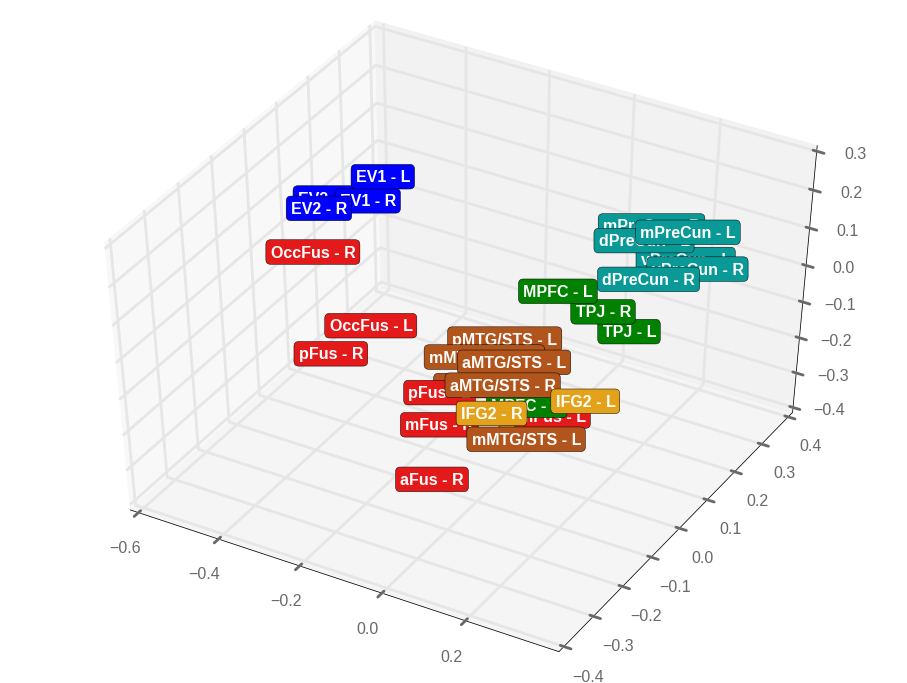

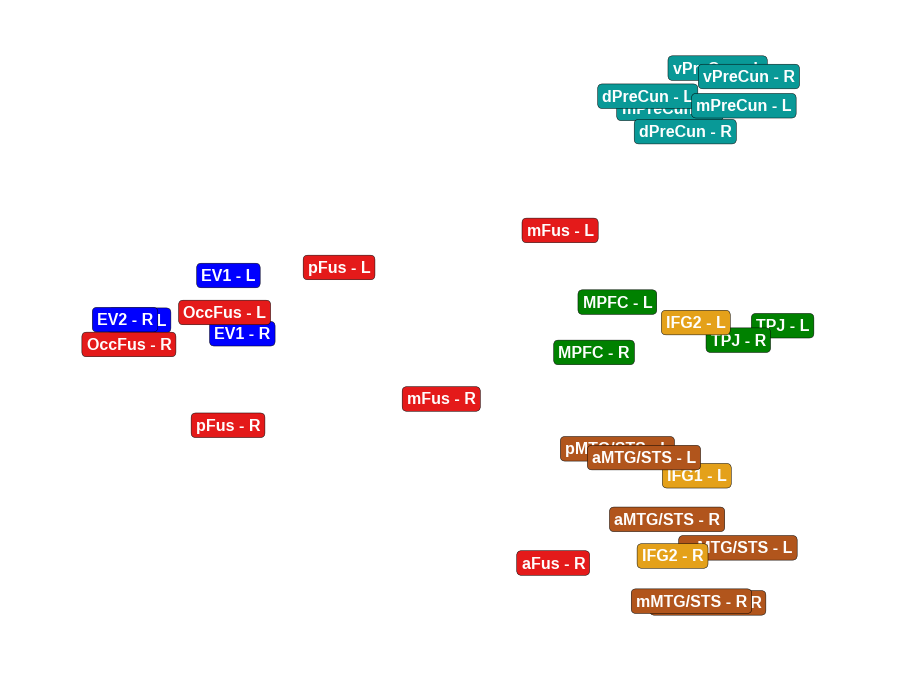

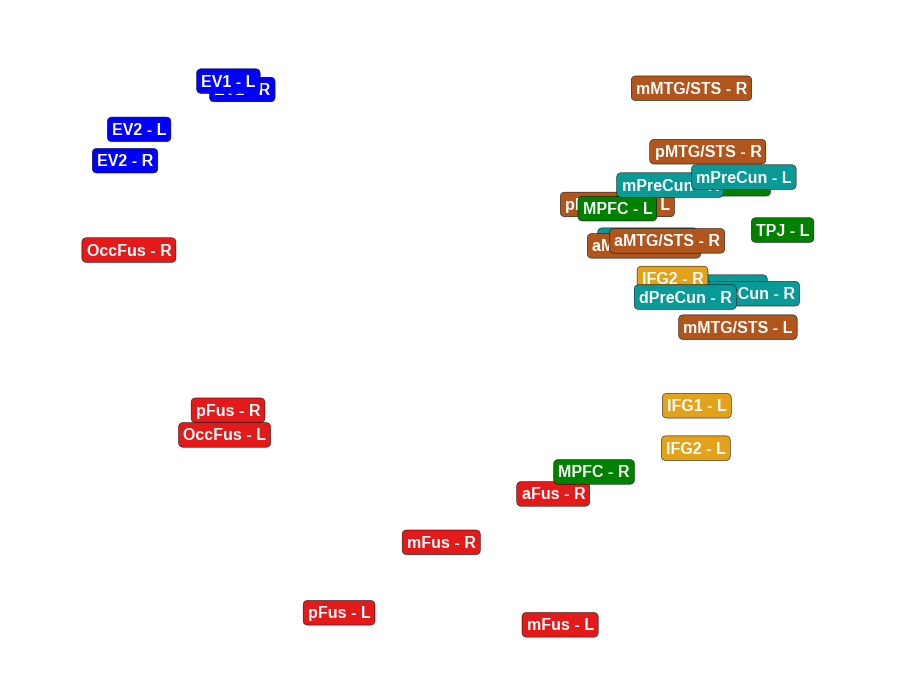

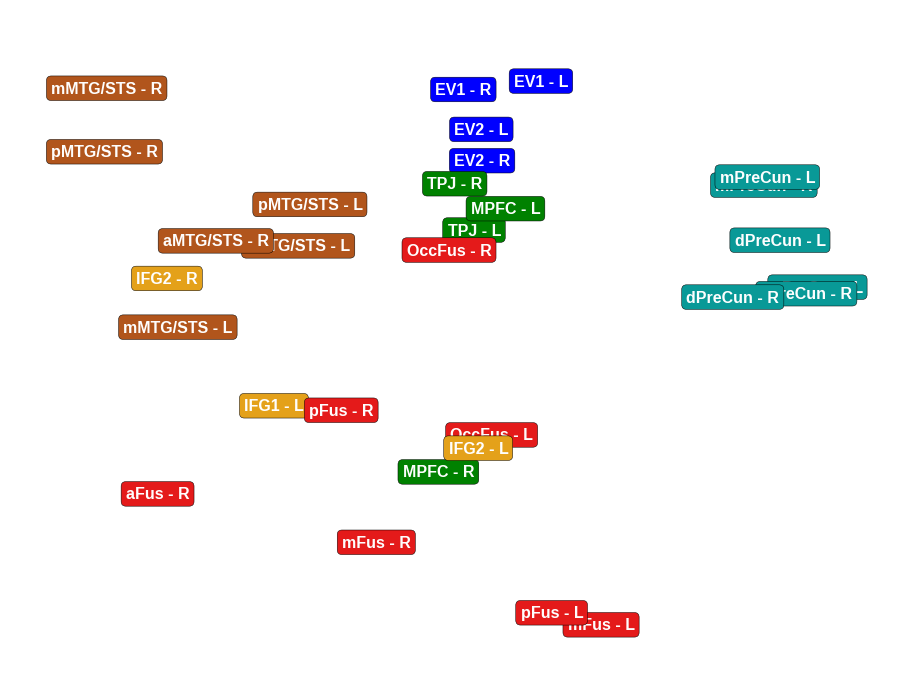

In [36]:
figs_mds = plot_all(coordinates, labels_, labels_color)

In [37]:
save = False
if save:
    figs_names = ['3d', '12', '13', '23']
    for fig, name in zip(figs_mds, figs_names):
        savefig(fig, 'allroi-mds-fullrdm_jimroi_fisher_sym_r10mm_{0}'.format(name))

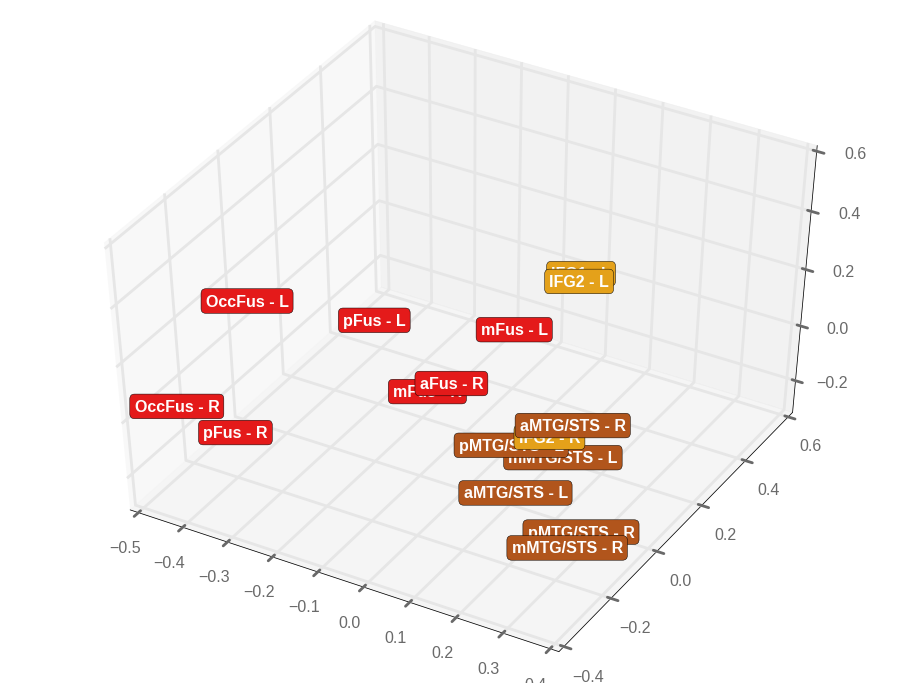

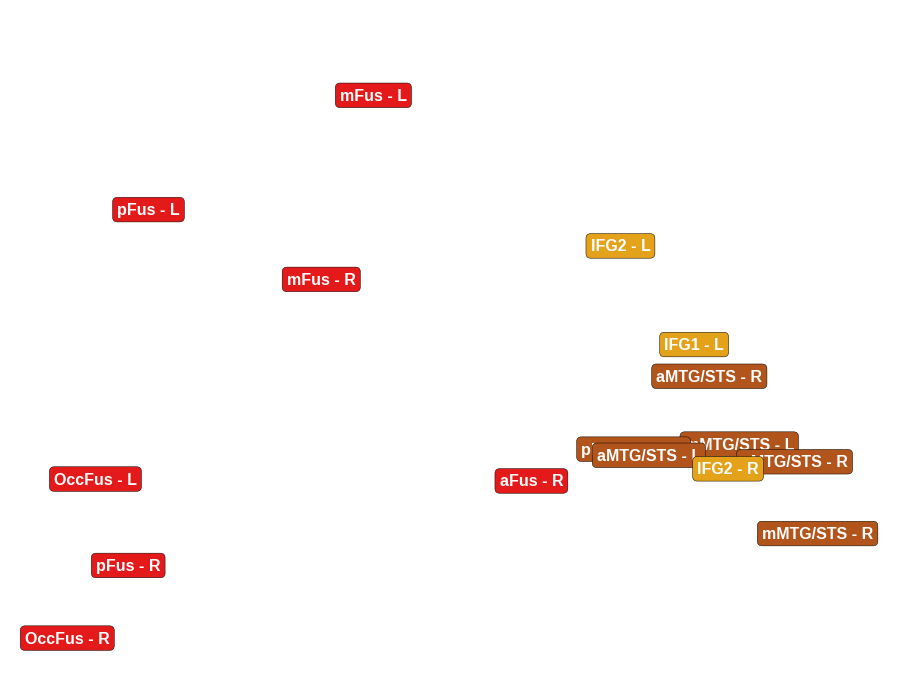

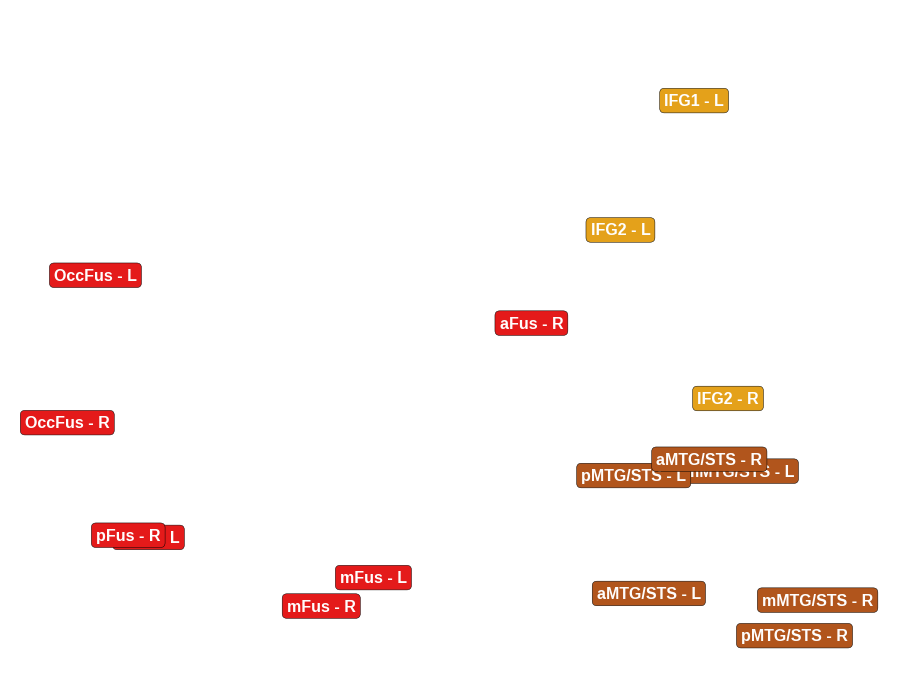

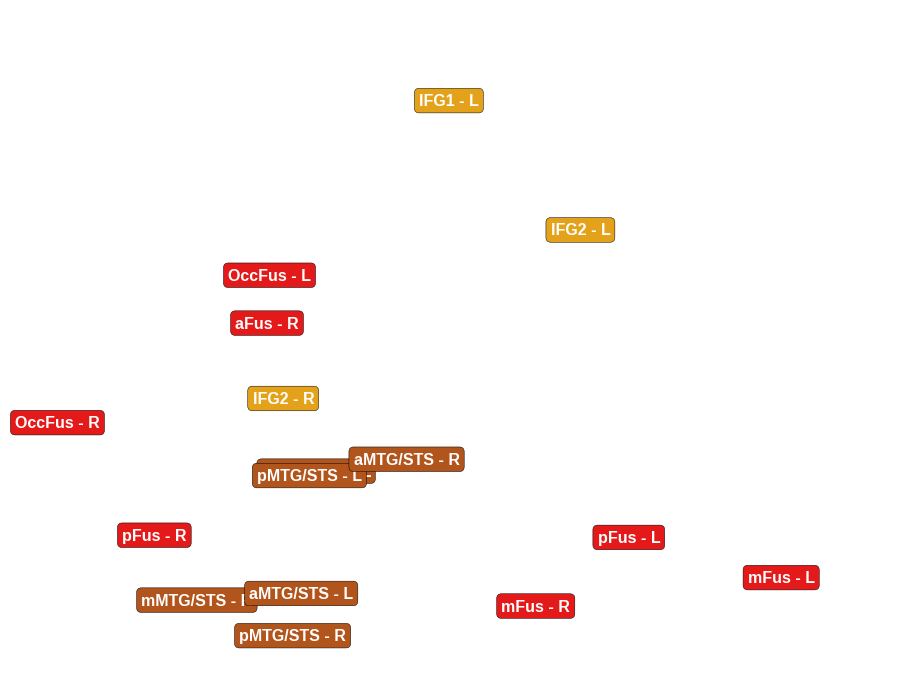

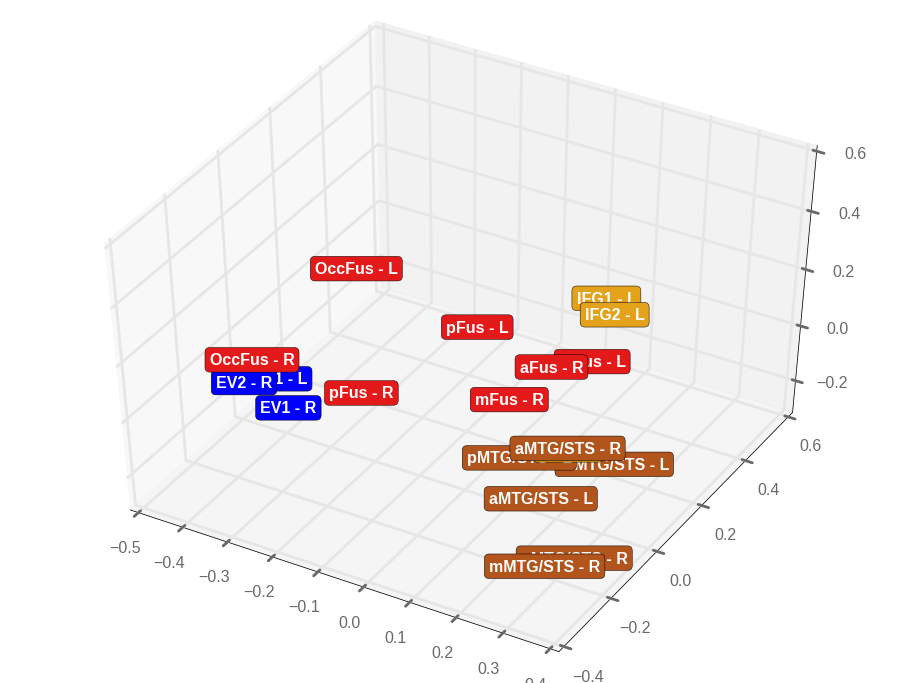

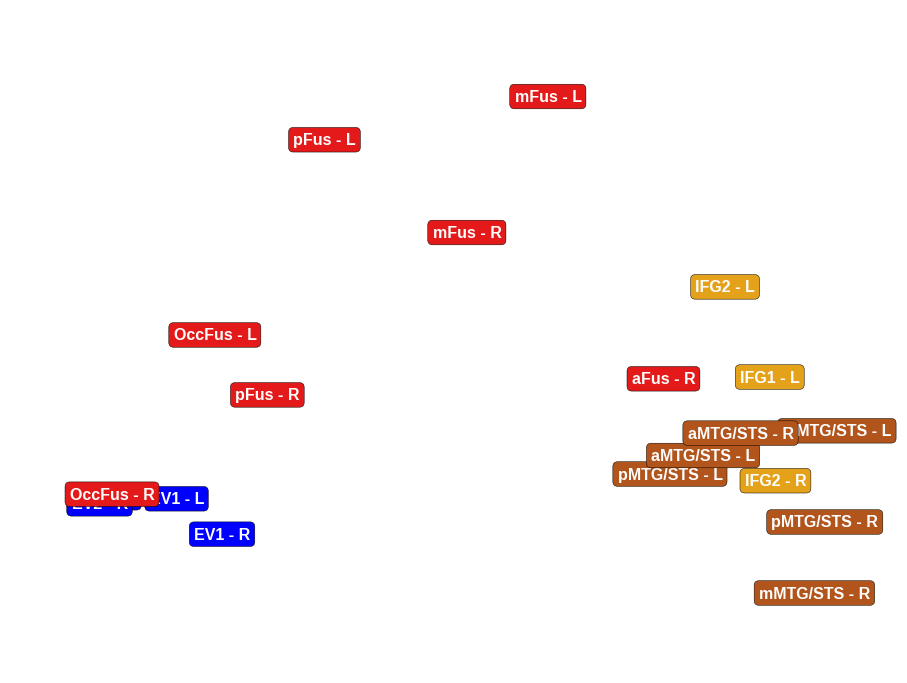

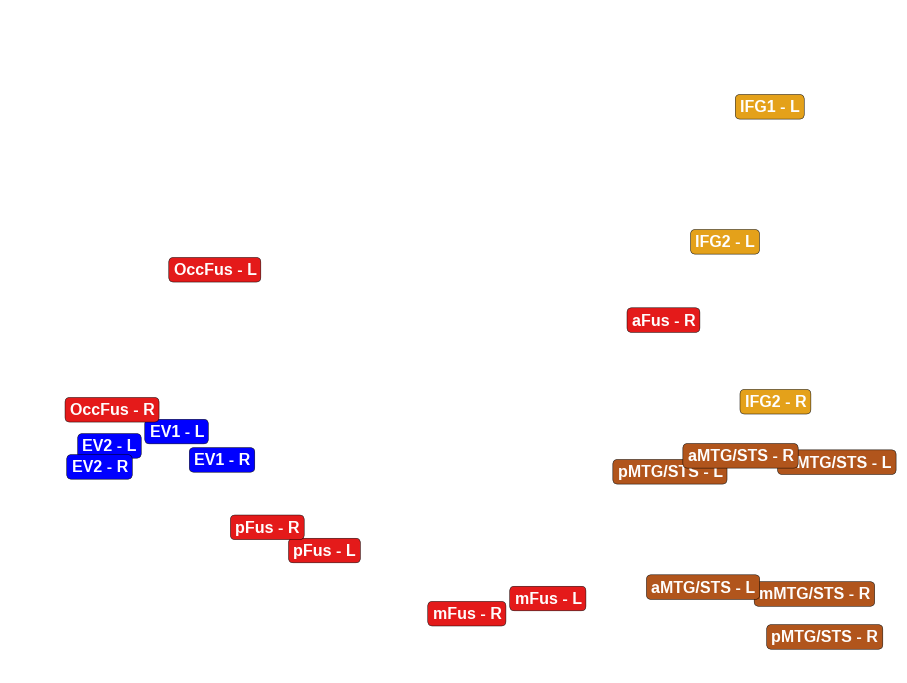

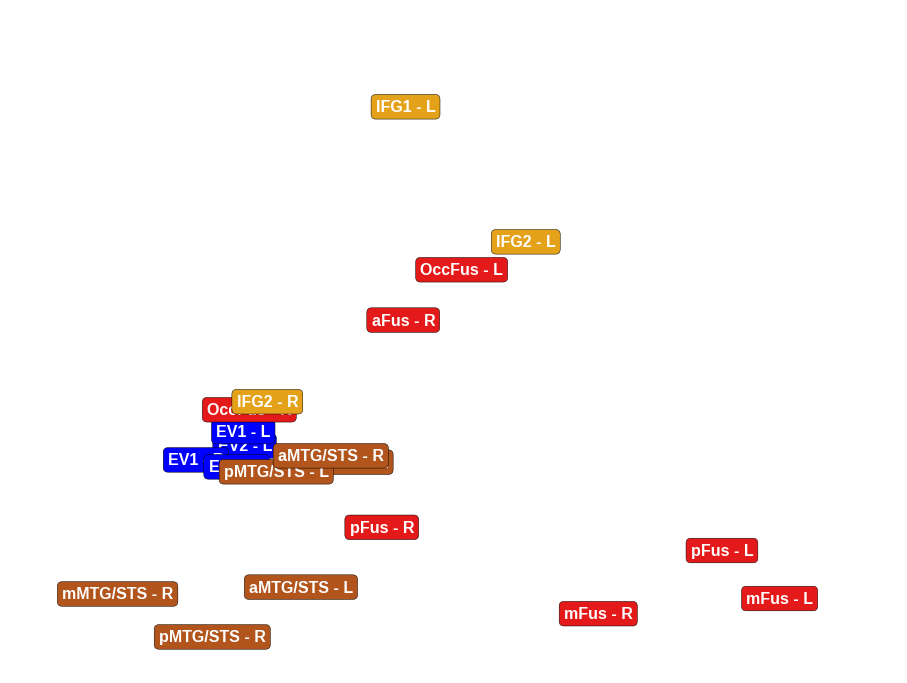

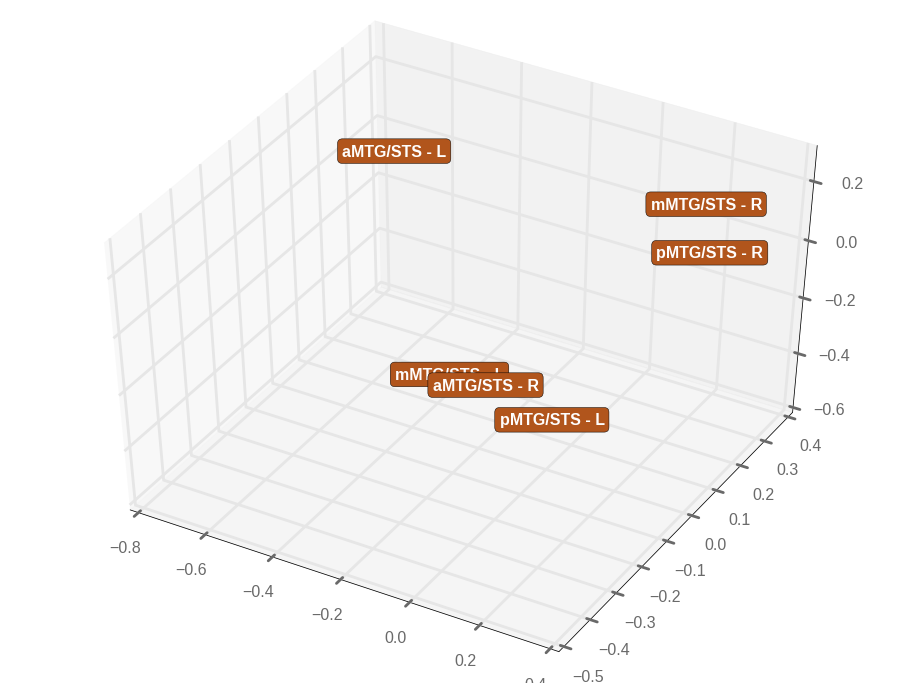

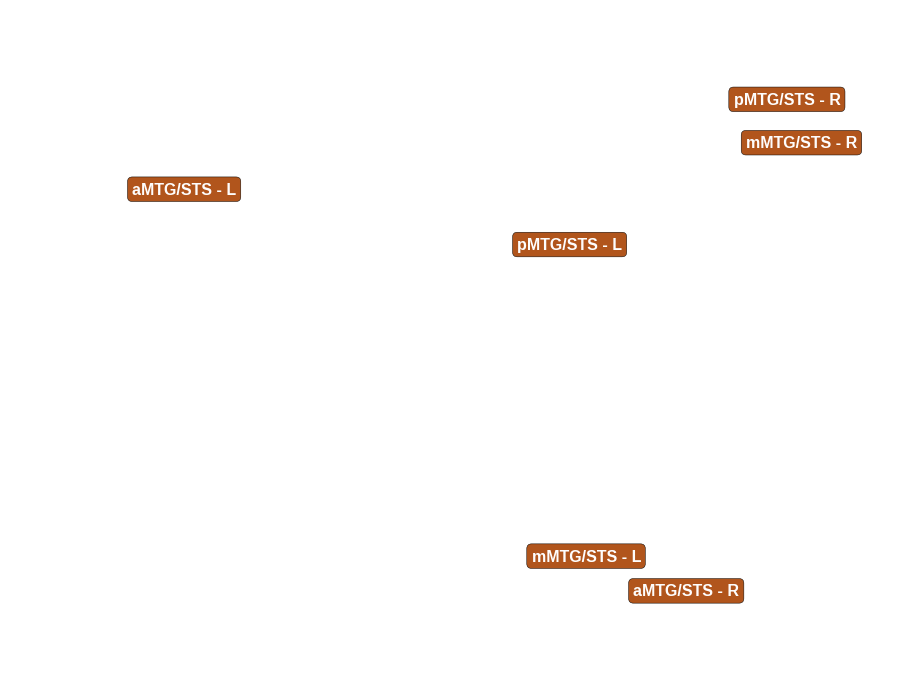

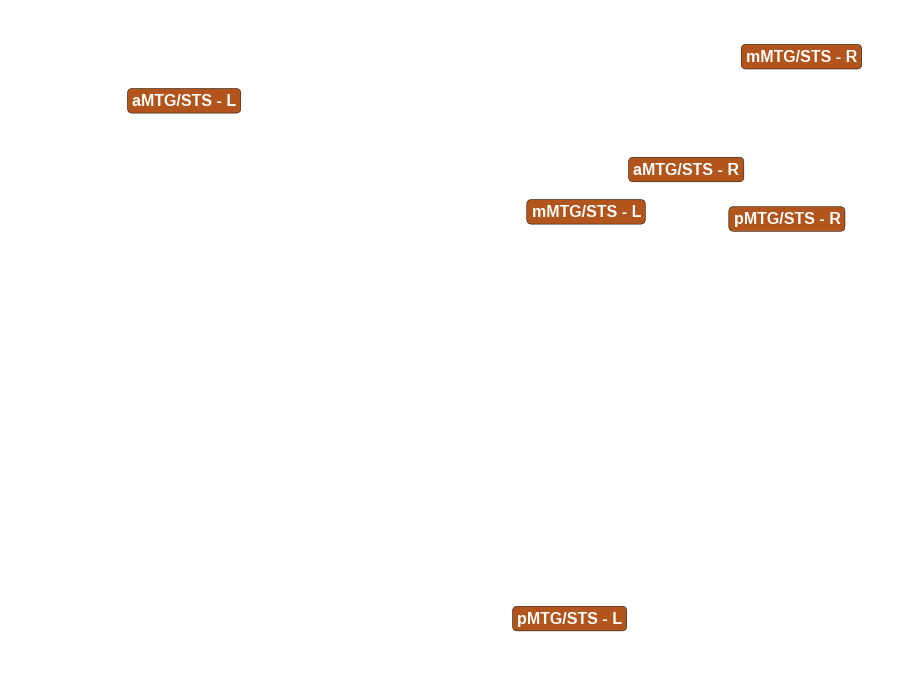

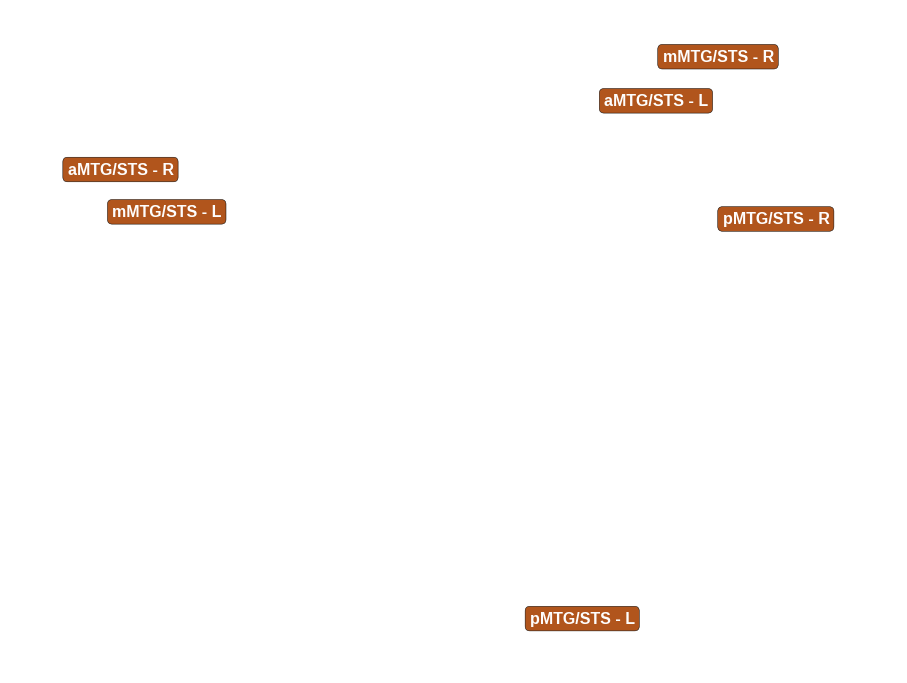

In [38]:
# plot only for subsets of areas
save = False
for syst in ['core', 'core+ev', 'dorsal_core']: 
    labels_ = distance_ds_subset[syst].sa.targets
    labels_color_ = get_labels_color(labels_)
    labels_ = [lbl.replace('MTG', 'MTG/STS') for lbl in labels_]
    figs_ = plot_all(coordinates_subset[syst],
                    labels_,
                    labels_color_)
    if save:
        for fig, dim in zip(figs_, ['3d', '12', '13', '23']):
            fnout = '{0}-mds-fullrdm_jimroi_fisher_sym_r10mm_{1}'.format(syst, dim)
            savefig(fig, fnout)

# Use Seaborn to make a nice plot of the correlation matrix

In [39]:
from scipy.stats import rankdata

In [40]:
def make_corrplot(distances, adj, labels_ord, mask_lower=False, mask_upper=False, 
                  percentiles=False, cmap=sns.diverging_palette(220, 10, as_cmap=True)):
    # get the full matrix
    labels = distances.fa.roi
    distances = distances.samples.copy()
    if percentiles:
        distances_ = squareform(distances, checks=False)
        distances_ = rankdata(distances_)/len(distances_)
        distances = squareform(distances_)
        # add 1. to the diagonal
        #np.fill_diagonal(distances, 1.)
        mx = 1.
    else:
        # make it a correlation
        distances = 1 - distances
        mx = np.triu(distances, k=1).max() * .7
    # mask only the lower diagonal
    mask = np.zeros_like(distances, dtype=np.bool)
    if mask_lower:
        mask[np.tril_indices_from(mask)] = True
        mask = np.logical_and(np.tril(mask), np.logical_not(adj != 0.))
        # keep the diagonal
        np.fill_diagonal(mask, False)
    if mask_upper:
        mask[np.triu_indices_from(mask)] = True
    # get only labels we have
    labels_ord = [l for l in labels_ord if l in labels]

    # get reordered idx
    order = [np.where(l == labels)[0][0] for l in labels_ord]
    distances_ord = distances.copy()
    mask_ord = mask.copy()

    distances_ord = distances_ord[order, :][:, order]
    mask_notsig = np.logical_not(adj != 0.)
    np.fill_diagonal(mask_notsig, False)
    mask_notsig = mask_notsig[:, order][order, :]
    mask_notsig[np.triu_indices_from(mask_notsig, k=1)] = False
    sns.set(style='white', context='poster')
    f, ax = plt.subplots(figsize=(14, 11))
    
    sns.heatmap(distances_ord, 
                mask=mask_ord, 
                cmap=cmap, 
            vmin=0, vmax=mx,
            square=True, ax=ax,
            xticklabels=labels_ord, yticklabels=labels_ord,
            linewidths=0,
            cbar_kws={"shrink": .95,
                      "ticks": np.round(np.linspace(-mx, mx, 9), 2)},
            rasterized=True,
            )
    return f

In [41]:
def convert2percentile(corr):
    corr_ = squareform(corr, checks=False)
    corr_ = rankdata(corr_)/len(corr_)
    return squareform(corr_)

In [42]:
def plot_heatmap(corr, labels, label2color, cmap, vmin=0., vmax=1.):
    sns.set(style='white', context='poster')
    f, ax = plt.subplots(figsize=(14, 11))

    sns.heatmap(corr, cmap=cmap, 
            vmin=vmin, vmax=vmax,
            square=True, ax=ax,
            xticklabels=labels, yticklabels=labels,
            linewidths=0,
            cbar_kws={"shrink": .95,
                      "ticks": np.round(np.linspace(0, 1, 5), 2)},
            rasterized=True,
            );
    # set colors
    for t in ax.get_xticklabels():
        t.set_weight('bold')
        lbl = t.get_text()
        t.set_color(label2color[lbl])

    for t in ax.get_yticklabels():
        t.set_weight('bold')
        lbl = t.get_text()
        t.set_color(label2color[lbl])
    
    return f, ax

In [43]:
# load the order of ROIs
import pandas as pd
df = pd.read_csv('new_roi_jim.csv')
labels_ord = list(df['Abbreviation'])

In [44]:
labels_ord = [
    # ev
    'EV1 - L', 'EV1 - R', 'EV2 - L', 'EV2 - R', 
    # ventral core system
    'OccFus - L', 'OccFus - R', 'pFus - L', 'pFus - R', 'mFus - L', 'mFus - R', 'aFus - R',
    # dorsal core system
    'pMTG - L', 'pMTG - R', 'mMTG - L', 'mMTG - R', 'aMTG - L', 'aMTG - R', 
    # anterior core system
    'IFG1 - L', 'IFG2 - L', 'IFG2 - R', 
    # tom
    'TPJ - L', 'TPJ - R', 'MPFC - L', 'MPFC - R', 
    # precuneus
    'dPreCun - L', 'dPreCun - R', 'mPreCun - L', 'mPreCun - R', 'vPreCun - L', 'vPreCun - R']

In [45]:
def reorder_dataset(ds, labels_ord):
    labels_orig = ds.sa.targets
    ds_ord = ds.copy()
    idx_reorder = [np.where(lbl == labels_orig)[0][0] for lbl in labels_ord]

    ds_ord = ds_ord[:, idx_reorder][idx_reorder, :]
    return ds_ord

In [46]:
# reorder dataset in correct plotting order
ds_ord = reorder_dataset(distance_ds, labels_ord)

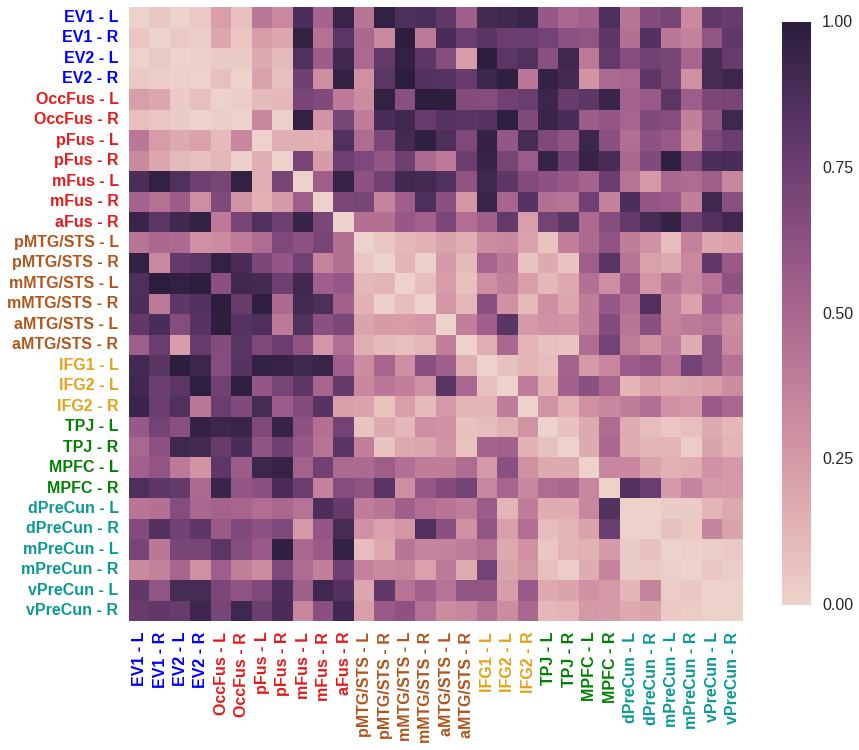

In [47]:
# Plot heatmap
cmap = cm.colors.ListedColormap(sns.cubehelix_palette(100))#sns.color_palette('Purples', n_colors=100))

label2color = {l: color for l, color in zip(labels, get_labels_color(labels))}
# rename MTG to MTG/STS
labels_ord_ = [lbl.replace('MTG', 'MTG/STS') for lbl in labels_ord]
label2color_ = {key.replace('MTG', 'MTG/STS'): value for key, value in label2color.iteritems()}
distance_mat_task = plot_heatmap(convert2percentile(ds_ord.samples), labels_ord_, label2color_, cmap)

In [48]:
save = False
if save:
    distance_mat_task[0].savefig('mds_plots/distance_mat_task.png', dpi=300)

# Plot MDS from hyperalignment

In [49]:
# get the right order of labels for this
roi_coord = pd.read_csv('new_roi_jim.csv')
labels_hpal = list(roi_coord['Abbreviation'])

In [50]:
res_hpal1 = h5load('roi_rdm_hpal_part1.hdf5')
res_hpal2 = h5load('roi_rdm_hpal_part2.hdf5')

In [51]:
# average across parts
hpal_distance = np.tanh((np.arctanh(res_hpal1) + np.arctanh(res_hpal2))/2)
# normalize by noise values, as in Guntupalli et al., 2016
diag = np.diag(hpal_distance).reshape((1, -1))
sqrt_diag = np.sqrt((diag * diag.T))
# normalize by noise and make distance
hpal_distance_norm = 1. - hpal_distance / sqrt_diag

In [52]:
# make it a ds so we can reorder it
hpal_distance_norm_ds = Dataset(hpal_distance_norm.copy())
hpal_distance_norm_ds.sa['targets'] = labels_hpal
hpal_distance_norm_ds = reorder_dataset(hpal_distance_norm_ds, labels_ord)
hpal_distance_norm = hpal_distance_norm_ds.samples
labels_hpal = labels_ord

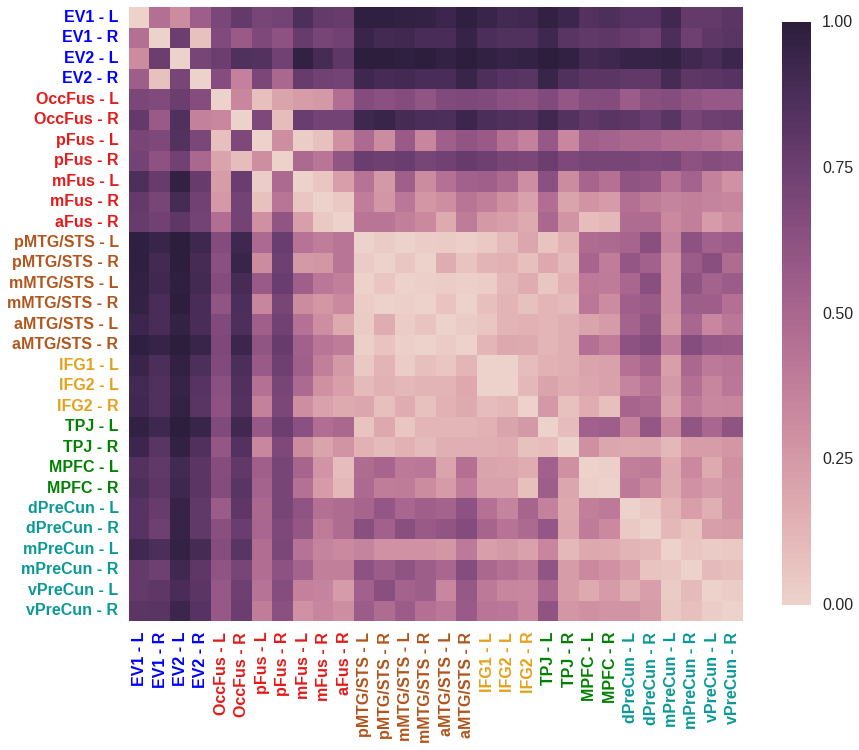

In [53]:
cmap = cm.colors.ListedColormap(sns.cubehelix_palette(100))

labels_hpal = [lbl.replace('MTG', 'MTG/STS') for lbl in labels_hpal]
distance_mat_hpal = plot_heatmap(convert2percentile(hpal_distance_norm), labels_hpal, label2color_, cmap)

In [54]:
save = False
if save:
    distance_mat_hpal[0].savefig('mds_plots/distance_mat_hpal.png', dpi=300)

In [55]:
# compute mds solution
coordinates_hpal = mdsf(hpal_distance_norm, k=3)

In [56]:
labels_hpal_color = [label2color_[lbl] for lbl in labels_hpal]

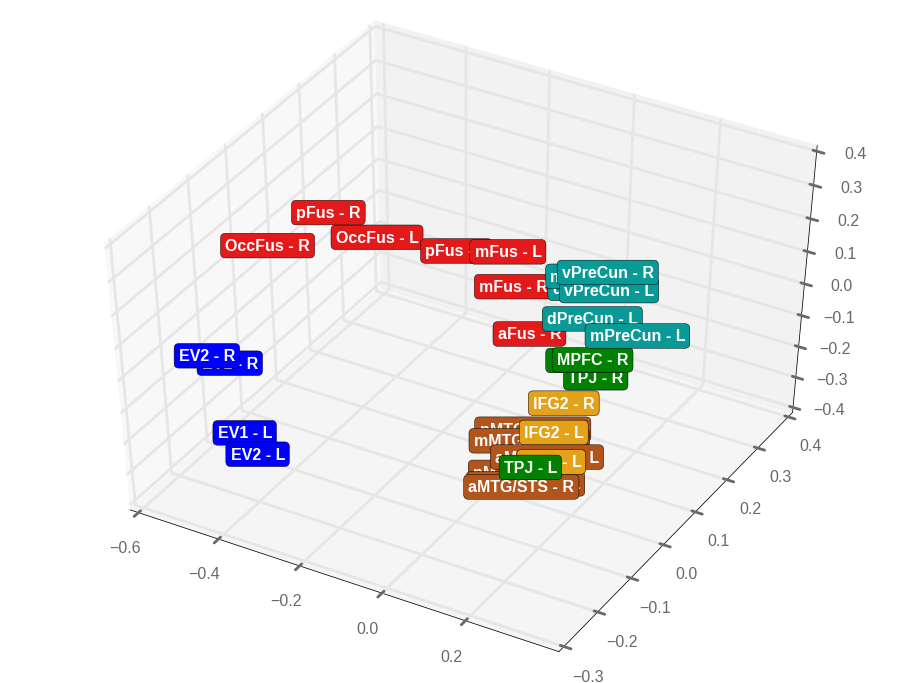

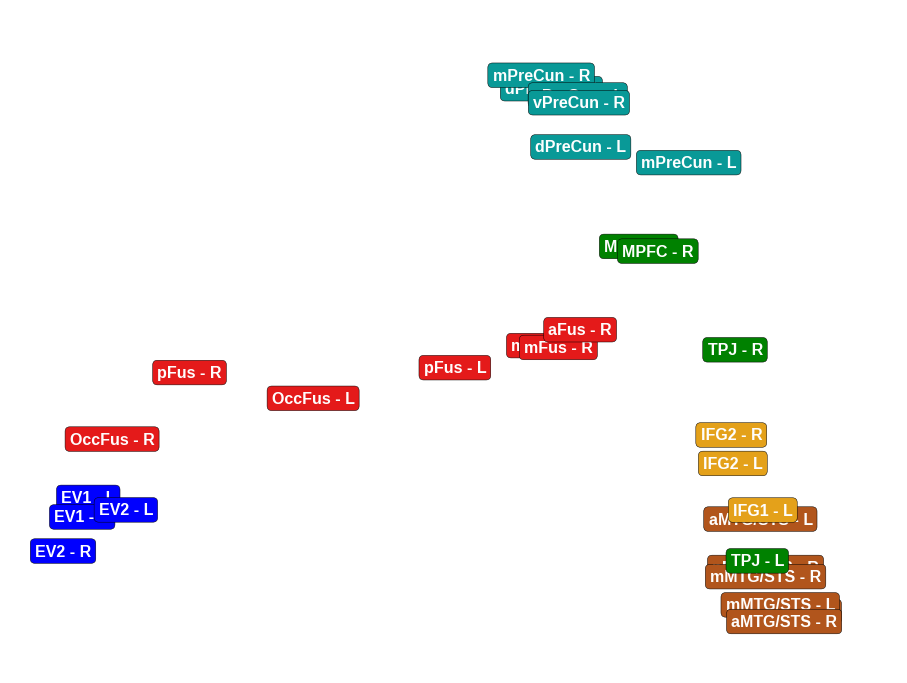

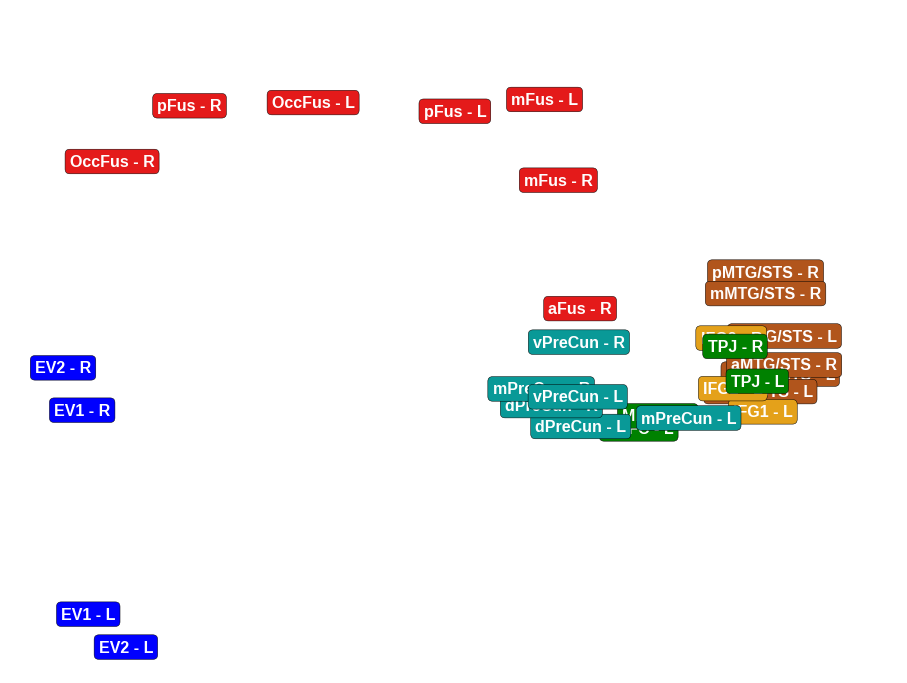

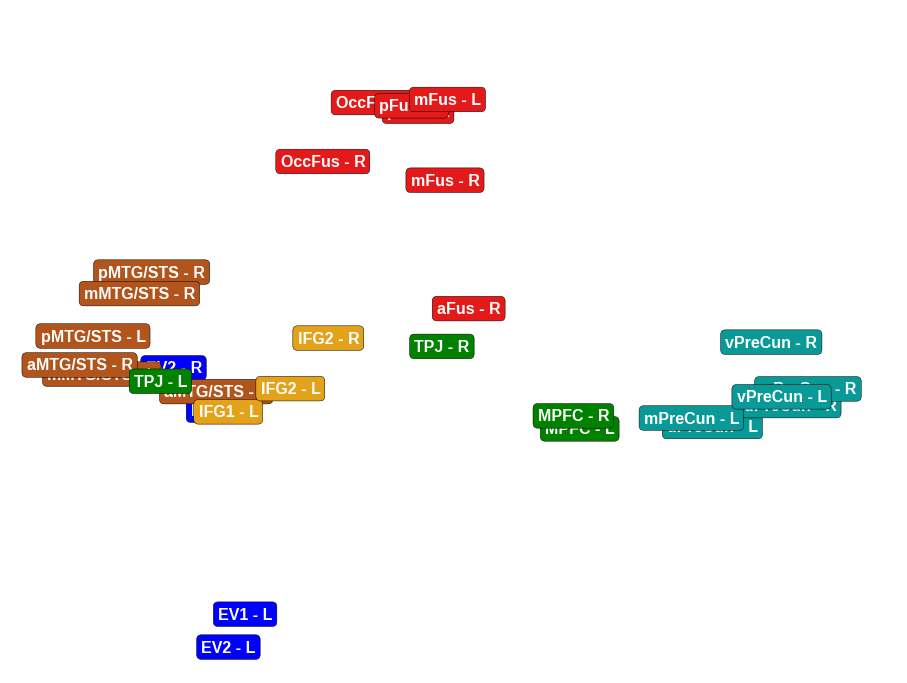

In [57]:
figs_mds_hpal = plot_all(coordinates_hpal, labels_hpal, labels_hpal_color)

In [58]:
save = False
if save:
    figs_names = ['3d', '12', '13', '23']
    for fig, name in zip(figs_mds_hpal, figs_names):
        savefig(fig, 'allroi-mds-hpal_timeseries_cv_r9mm_{0}'.format(name))

In [59]:
# plot subset for hpal as well
hpal_distance_norm_ds.fa['roi'] = hpal_distance_norm_ds.sa.targets
distance_ds_hpal_subset = {
    'core': filter_ds(hpal_distance_norm_ds, systems['ventral_core'] + 
                      systems['dorsal_core'] + 
                      systems['anterior_core']),
    'core+ev': filter_ds(hpal_distance_norm_ds, systems['ventral_core'] + 
                      systems['dorsal_core'] + 
                      systems['anterior_core'] +
                      systems['ev']),
    'dorsal_core': filter_ds(hpal_distance_norm_ds, systems['dorsal_core'])
}

# get coordinates
coordinates_hpal_subset = dict()

for lbl, ds in distance_ds_hpal_subset.iteritems():
    coord = mdsf(ds.samples, k=3)
    # swap first and second dimension for 'core' so that it goes left to right
    if lbl == 'core':
        coord[:, 0] *= -1
        coord[:, 1] *= -1
    if lbl == 'dorsal_core':
        coord[:, 1] *= -1
    coordinates_hpal_subset[lbl] = coord

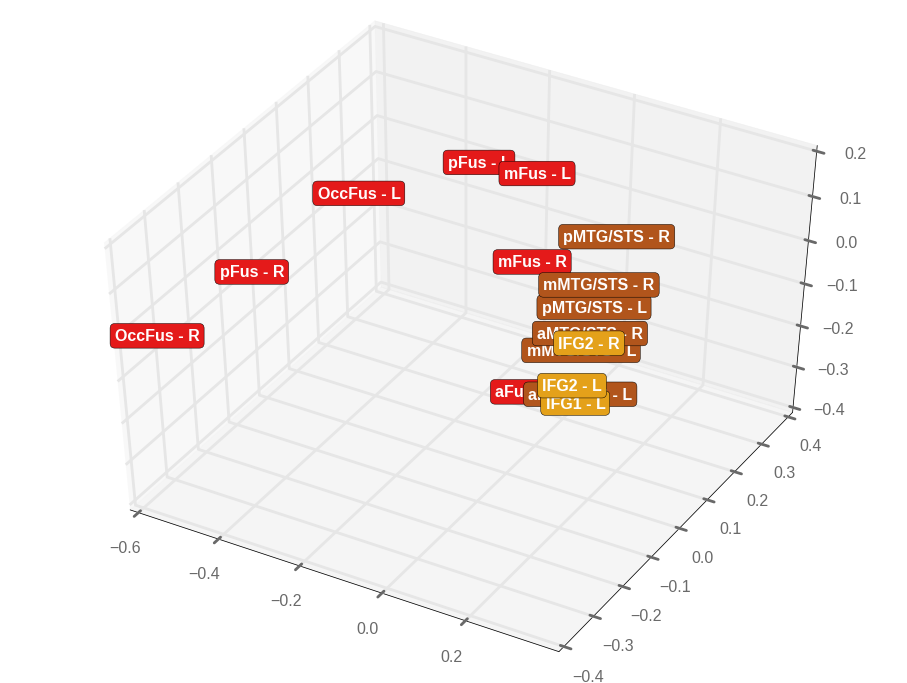

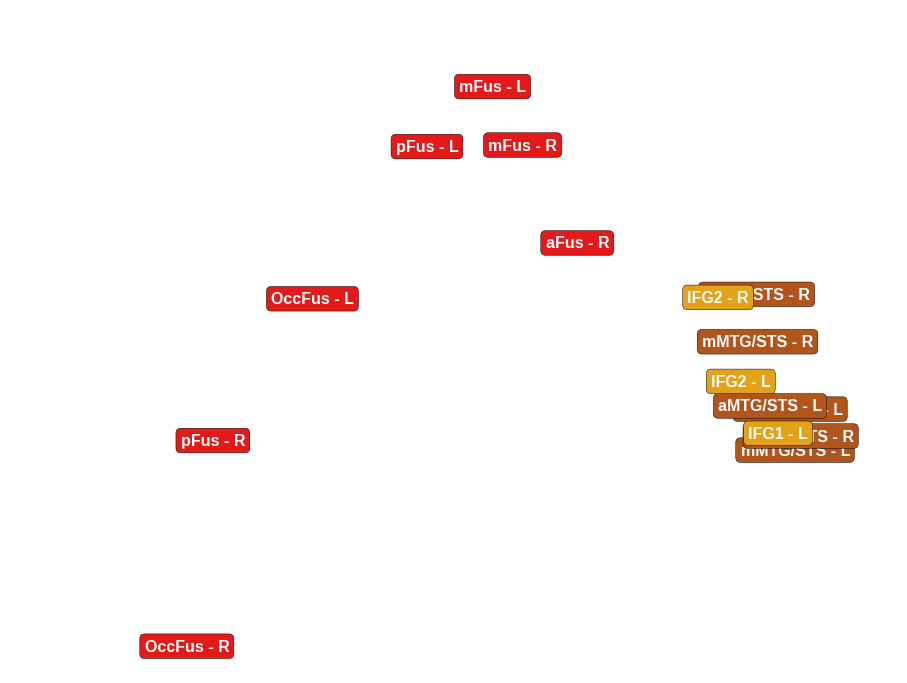

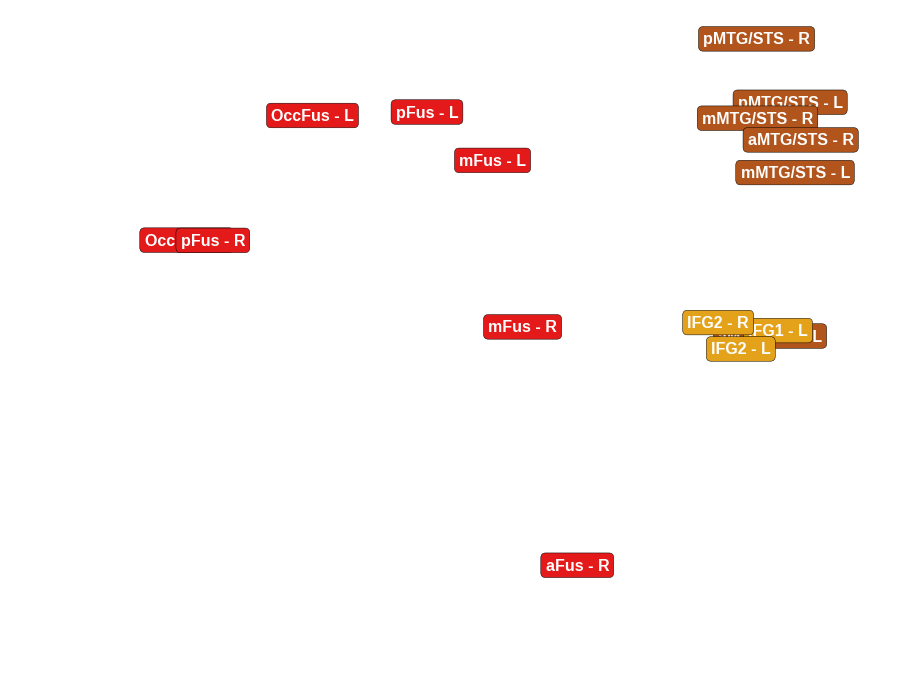

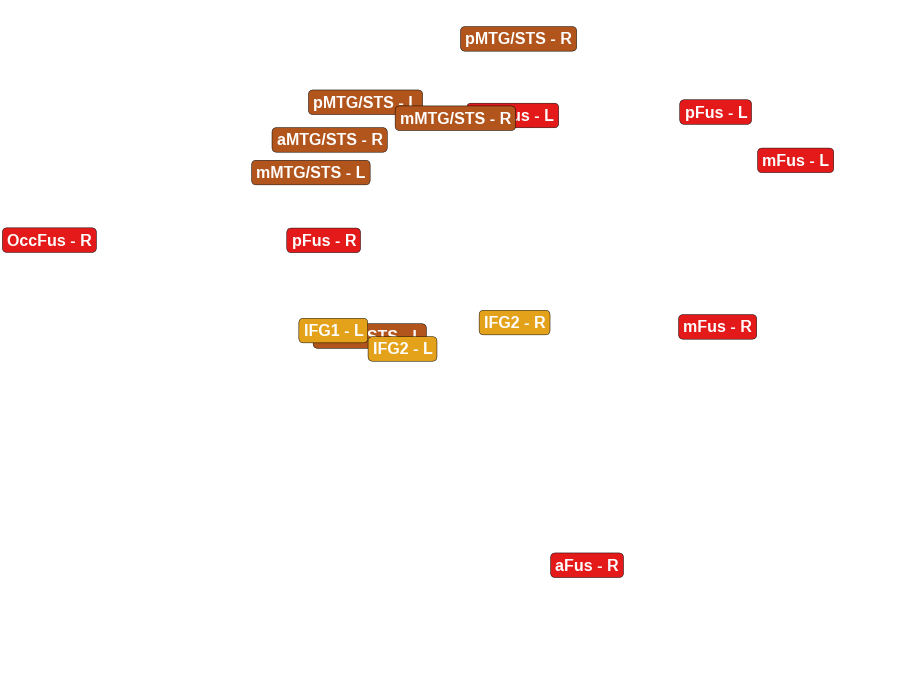

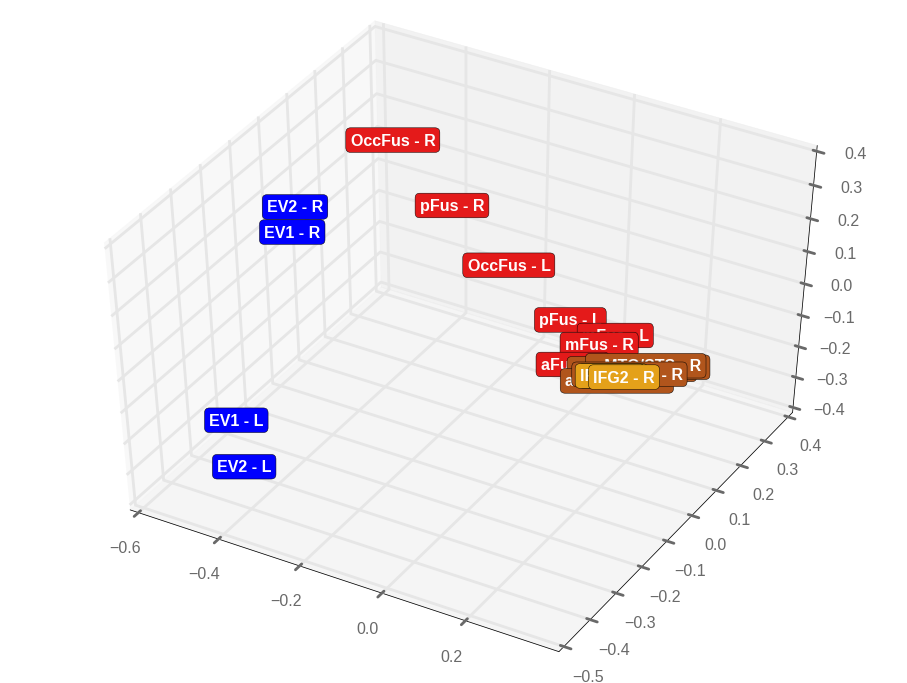

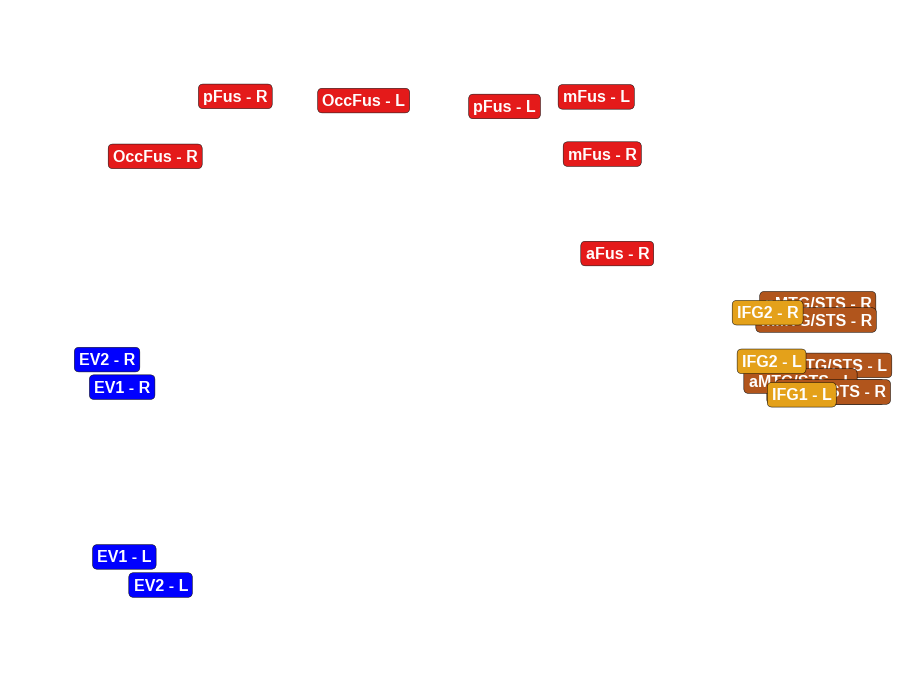

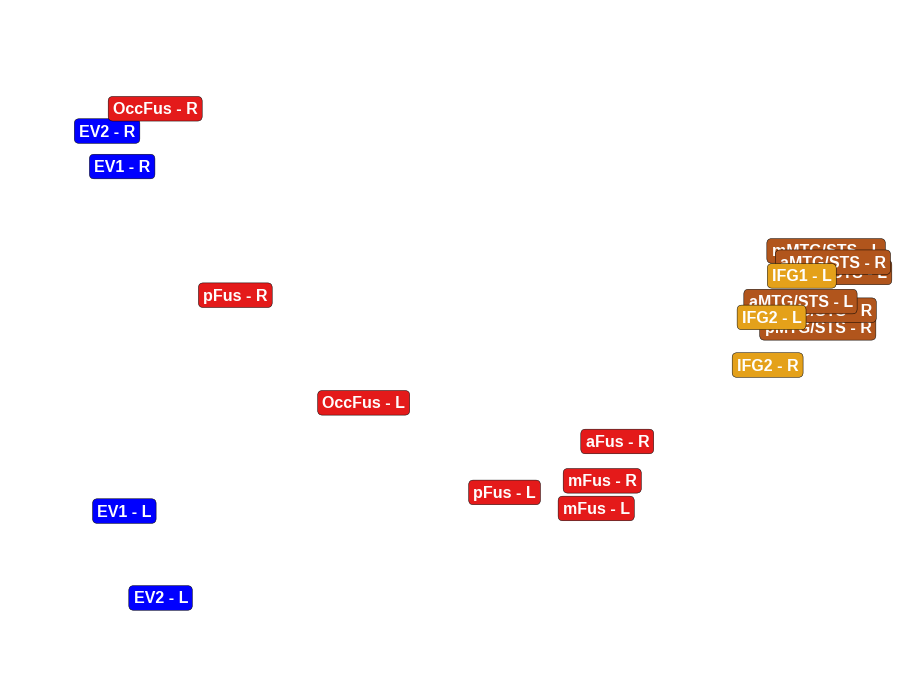

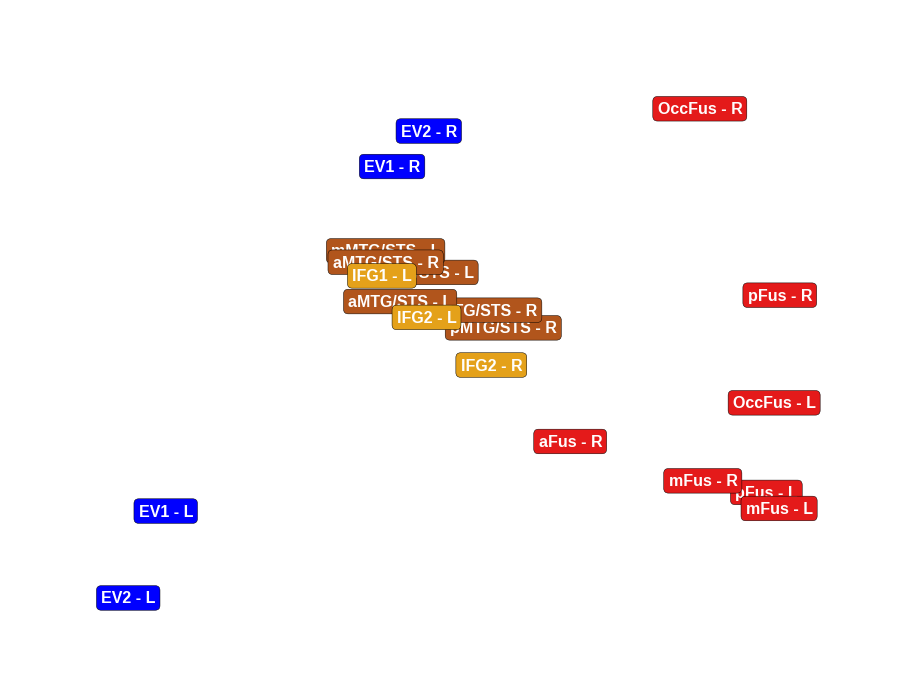

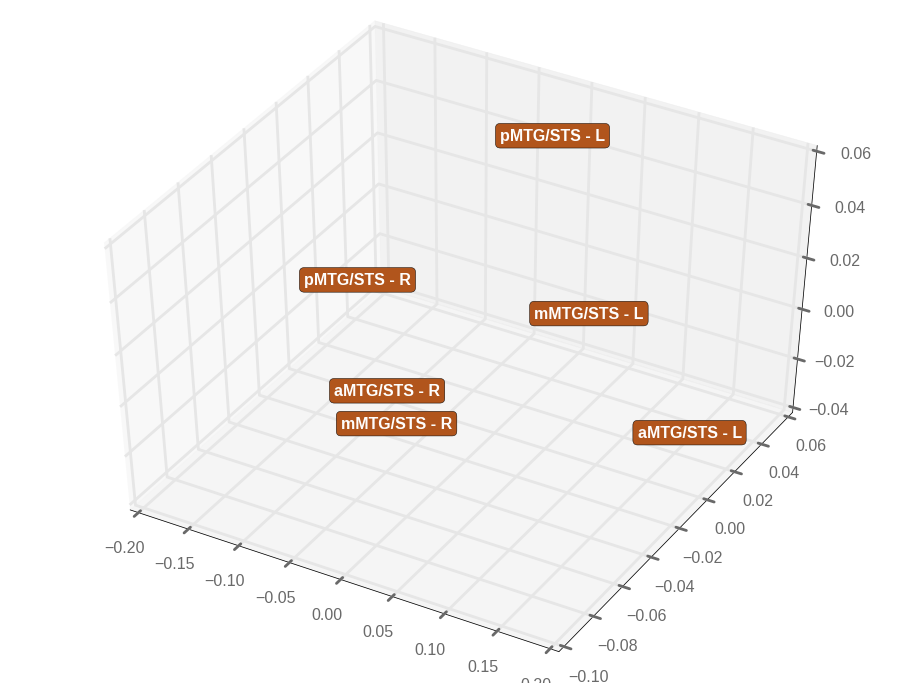

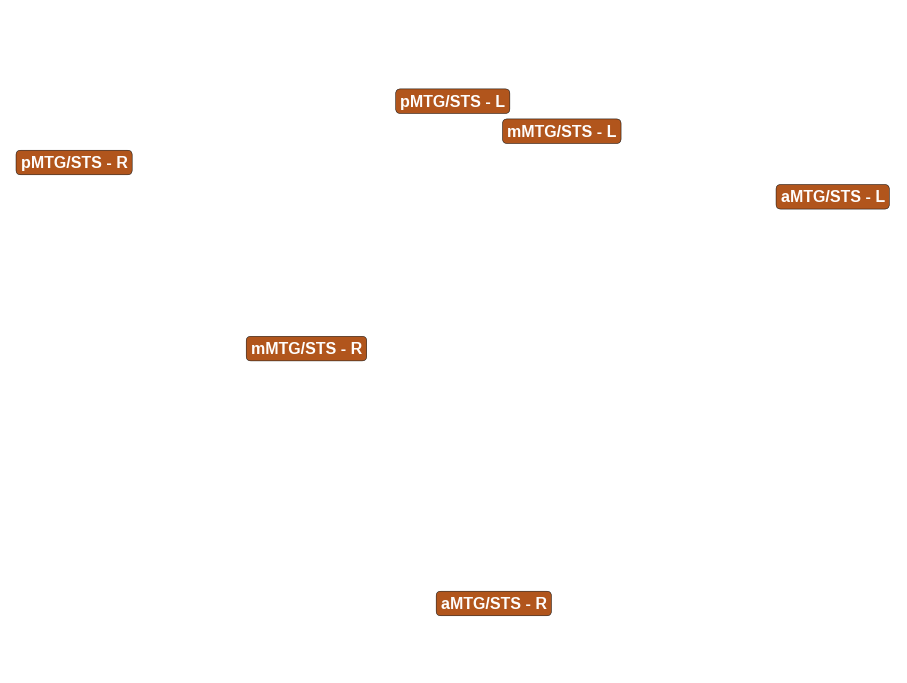

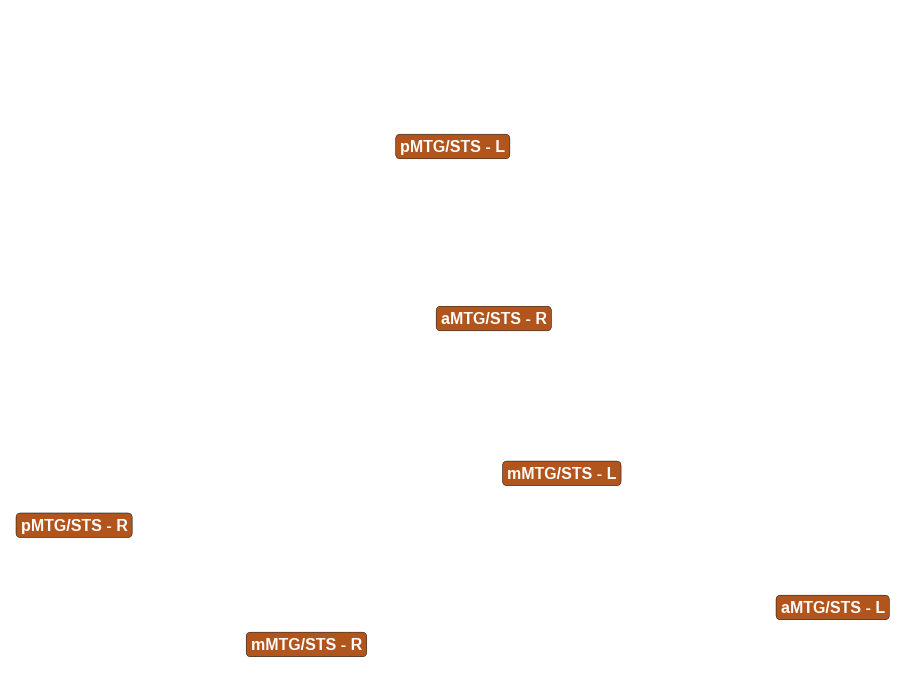

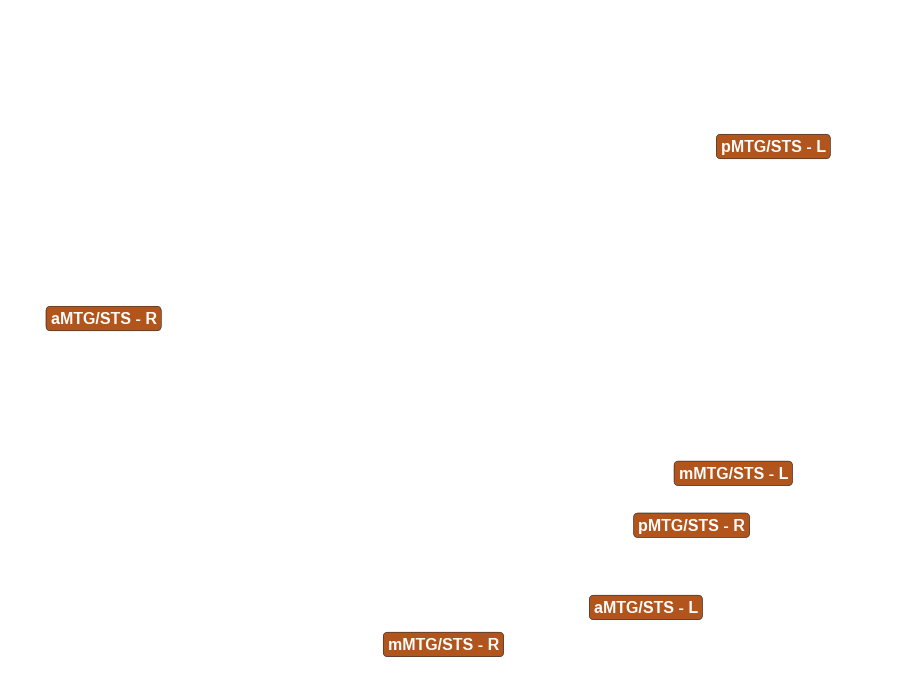

In [60]:
# plot only for subsets of areas
save = False
for syst in ['core', 'core+ev', 'dorsal_core']: 
    labels_ = distance_ds_hpal_subset[syst].sa.targets
    labels_color_ = get_labels_color(labels_)
    labels_ = [lbl.replace('MTG', 'MTG/STS') for lbl in labels_]
    figs_ = plot_all(coordinates_hpal_subset[syst],
                    labels_,
                    labels_color_)
    if save:
        for fig, dim in zip(figs_, ['3d', '12', '13', '23']):
            fnout = '{0}-mds-hpal_timeseries_cv_r9mm_{1}'.format(syst, dim)
            savefig(fig, fnout)

# Plot circular graph

In [61]:
from mne.viz import circular_layout, plot_connectivity_circle

In [62]:
labels_hpal_dorsal2rostral = [
'EV1 - L',
'EV1 - R',
'EV2 - L',
'EV2 - R',
'OccFus - L',
'OccFus - R',
'pFus - L',
'pFus - R',
'mFus - L',
'mFus - R',
'aFus - R',
'pMTG - L',
'pMTG - R',
'mMTG - L',
'mMTG - R',
'aMTG - L',
'aMTG - R',
'IFG1 - L',
'IFG2 - L',
'IFG2 - R',
'MPFC - L',
'MPFC - R',
'TPJ - L',
'TPJ - R',
'dPreCun - L',
'dPreCun - R',
'mPreCun - L',
'mPreCun - R',
'vPreCun - L',
'vPreCun - R',
]

In [63]:
labels_lh = []
labels_rh = []
for label in labels_hpal_dorsal2rostral:
    if label.endswith('L'):
        labels_lh.append(label)
    else:
        labels_rh.append(label)
        
# make order
node_order = []
node_order.extend(labels_lh[::-1])
node_order.extend(labels_rh)

In [64]:
node_angles = circular_layout(labels, node_order, start_pos=90,
                              group_boundaries=[0, len(labels_lh)])

In [65]:
# rank correlation values
adj_triu = np.abs(adj[np.triu_indices_from(adj, k=1)])
nonzero = adj_triu > 0
adj_triu_nonzero = adj_triu[nonzero]
adj_triu_nonzero = rankdata(adj_triu_nonzero)/len(adj_triu_nonzero)
adj_triu[nonzero] = adj_triu_nonzero

adj_rank = adj.copy()
adj_rank[np.triu_indices_from(adj_rank, k=1)] = adj_triu
adj_rank.T[np.triu_indices_from(adj_rank, k=1)] = adj_triu

In [66]:
n_sig_corr = np.sum(adj_rank[np.triu_indices_from(adj_rank, k=1)] > 0)

In [67]:
print n_sig_corr

203


In [68]:
cmap = cm.colors.ListedColormap(sns.cubehelix_palette(10))

In [69]:
# rename MTG to MTG/STS
labels = [lbl.replace('MTG', 'MTG/STS') for lbl in labels]

In [70]:
connectivity_common_kwargs = dict(
node_angles=node_angles, 
node_colors=labels_color,
colormap=cmap,
fontsize_names=18,
fontsize_colorbar=14,
colorbar_size=0.25,
interactive=False,
node_linewidth=4,
linewidth=2,
vmin=0,
vmax=1,
colorbar_pos=(-0.4, 0.5),
show=False,
textcolor='black',
facecolor='white',
node_edgecolor='white'
)

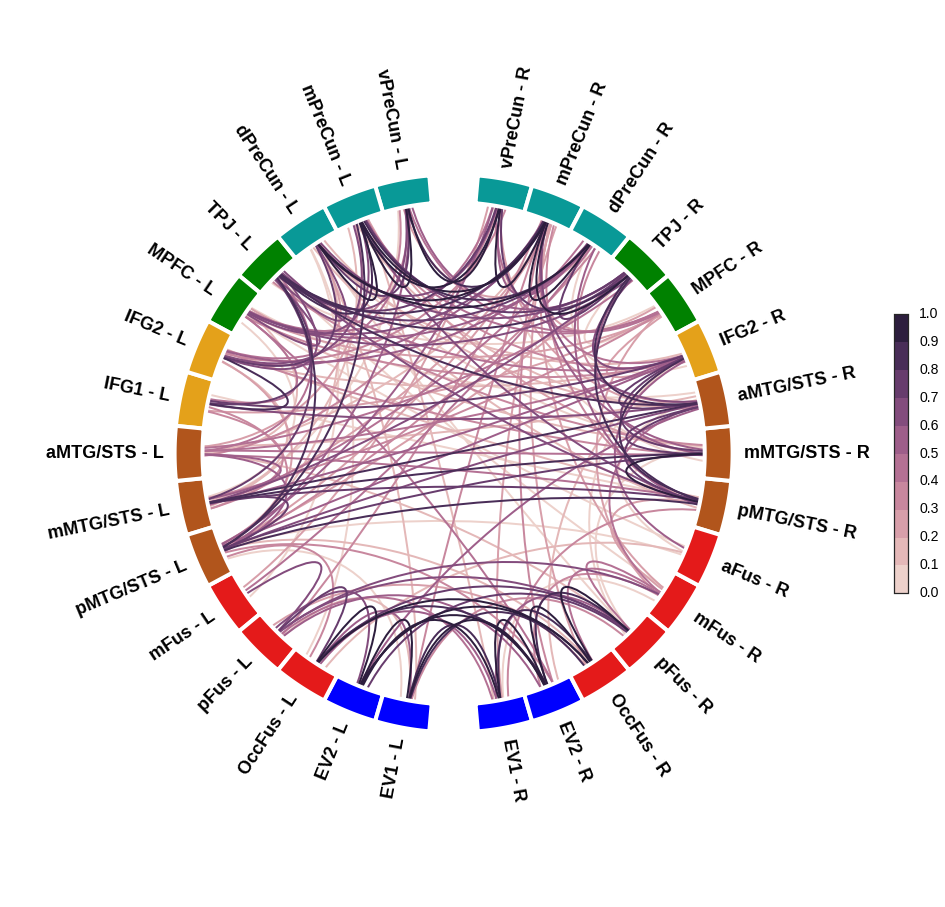

In [71]:
fig = plt.figure(figsize=(20, 20), facecolor='white')
f, ax = plot_connectivity_circle(adj_rank, labels, n_lines=n_sig_corr,
                                 fig=fig, **connectivity_common_kwargs)
for t in ax.texts:
    t.set_weight('bold')

In [72]:
#plot_n_corr = np.round(np.linspace(10, n_sig_corr, 6)).astype(int)
plot_n_corr = range(10, n_sig_corr + 1, 40) + [n_sig_corr]
print(plot_n_corr)

[10, 50, 90, 130, 170, 203]


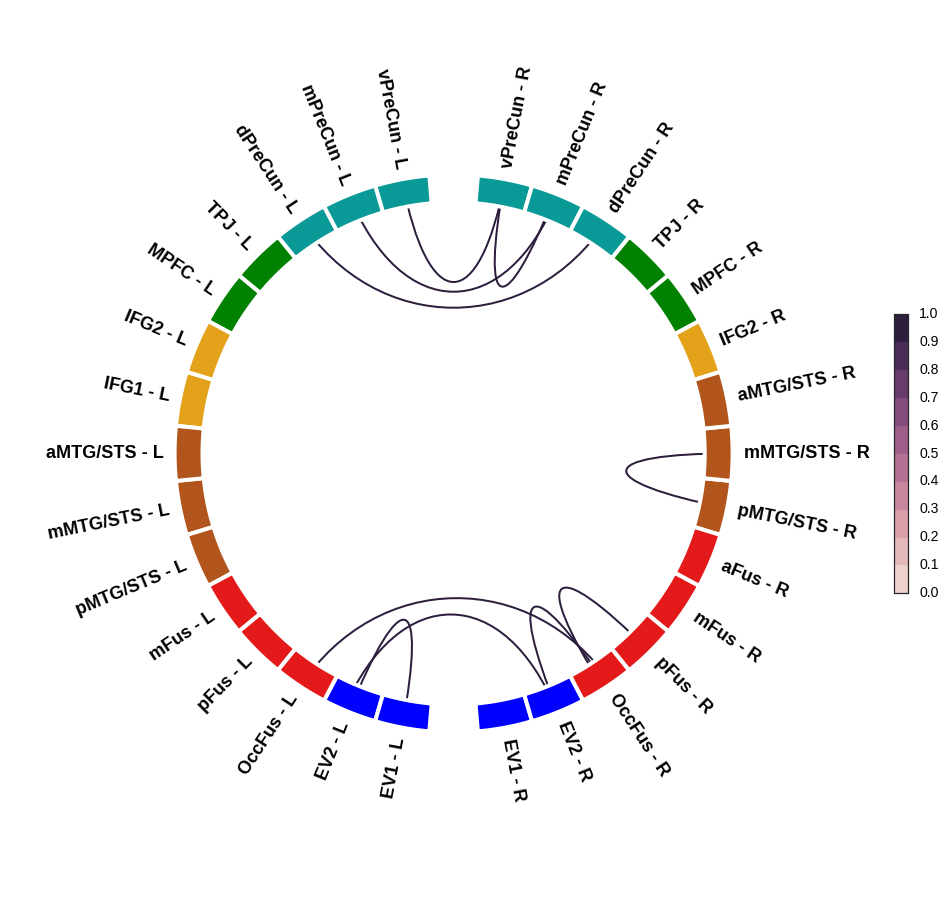

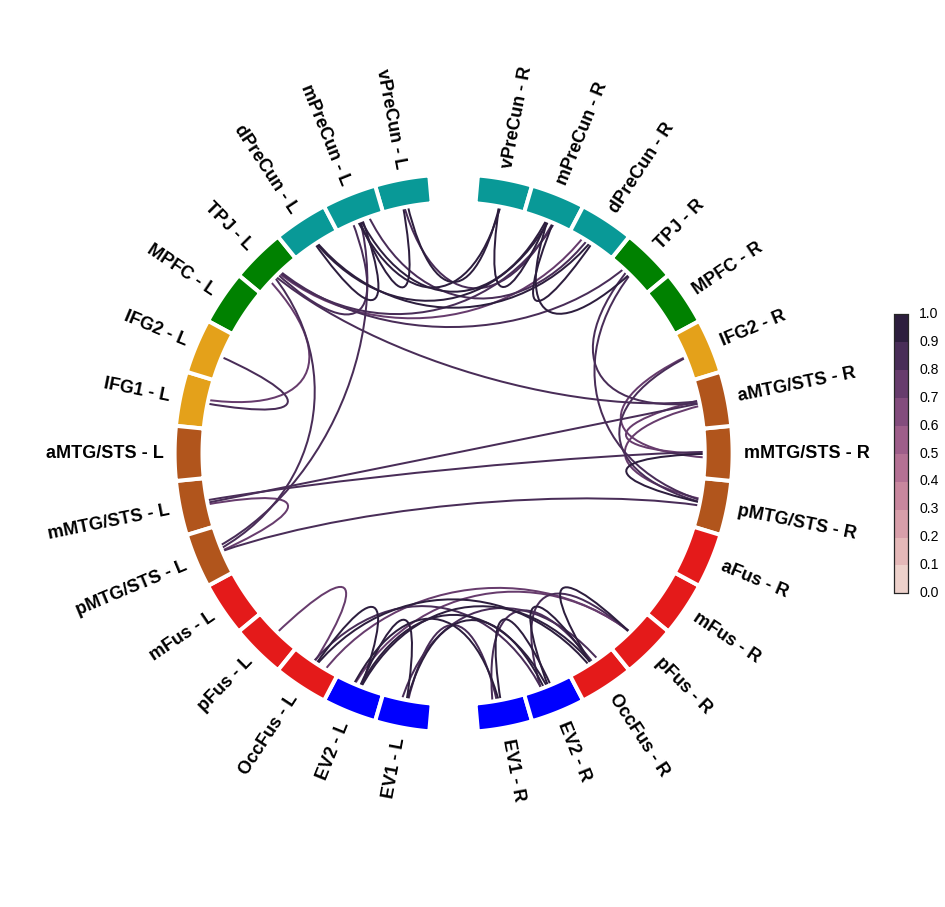

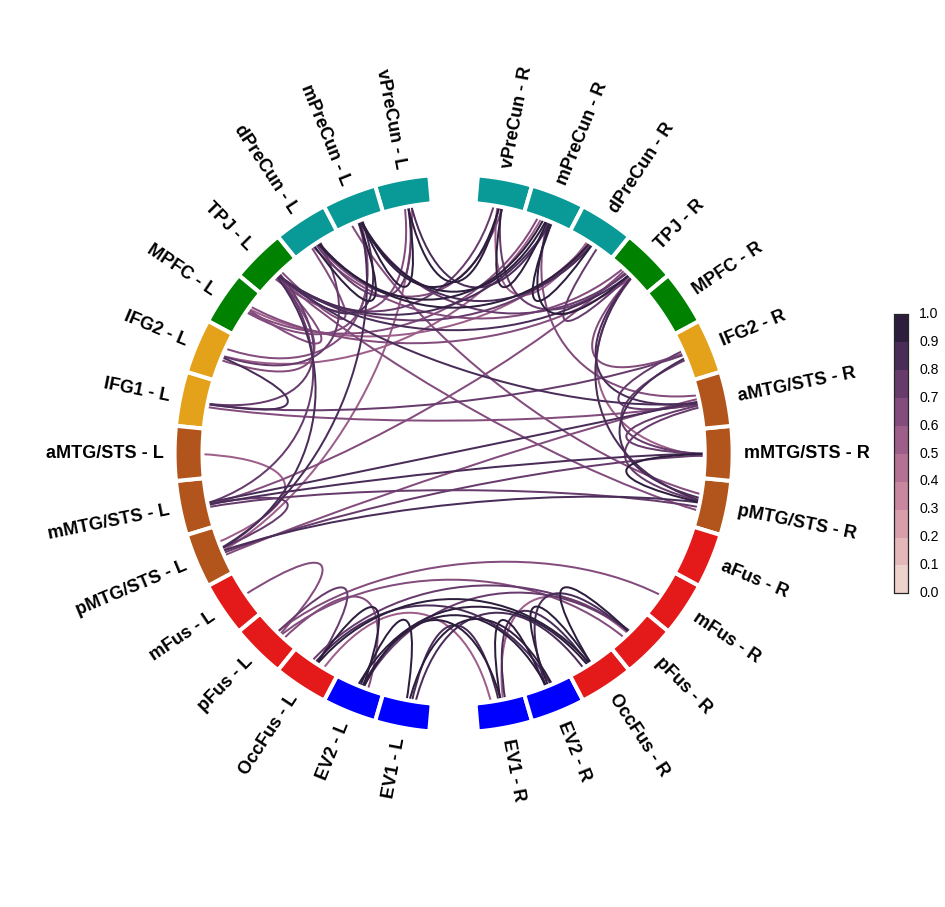

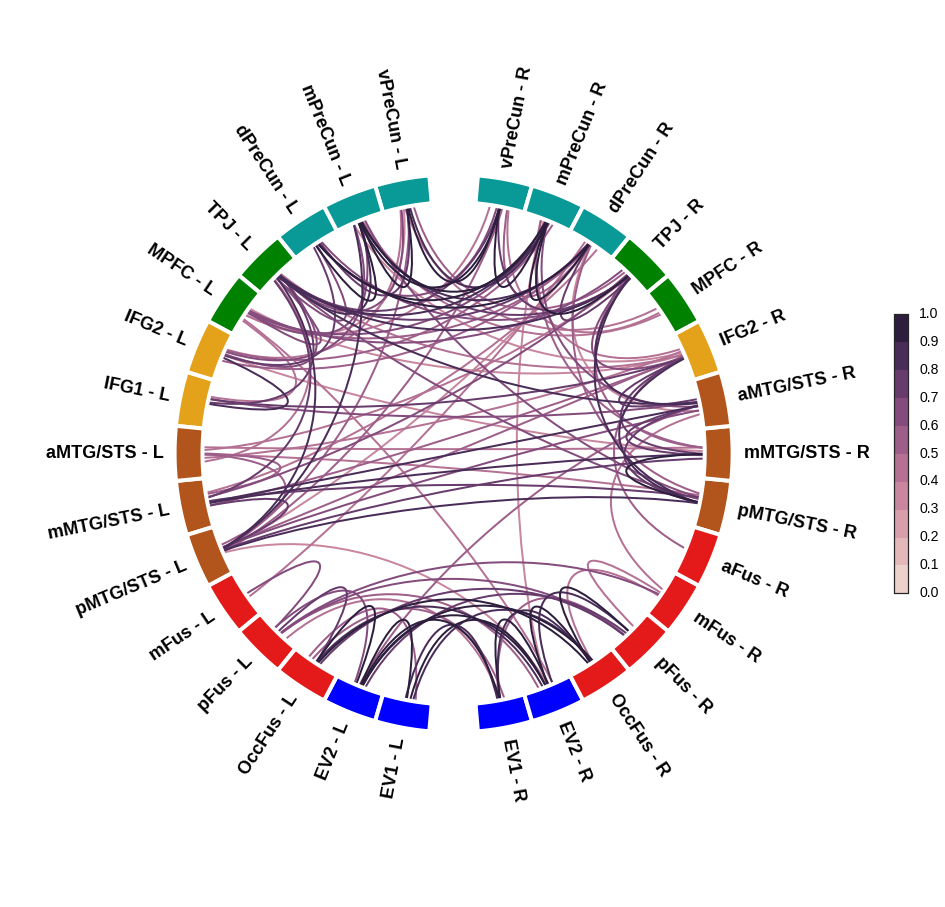

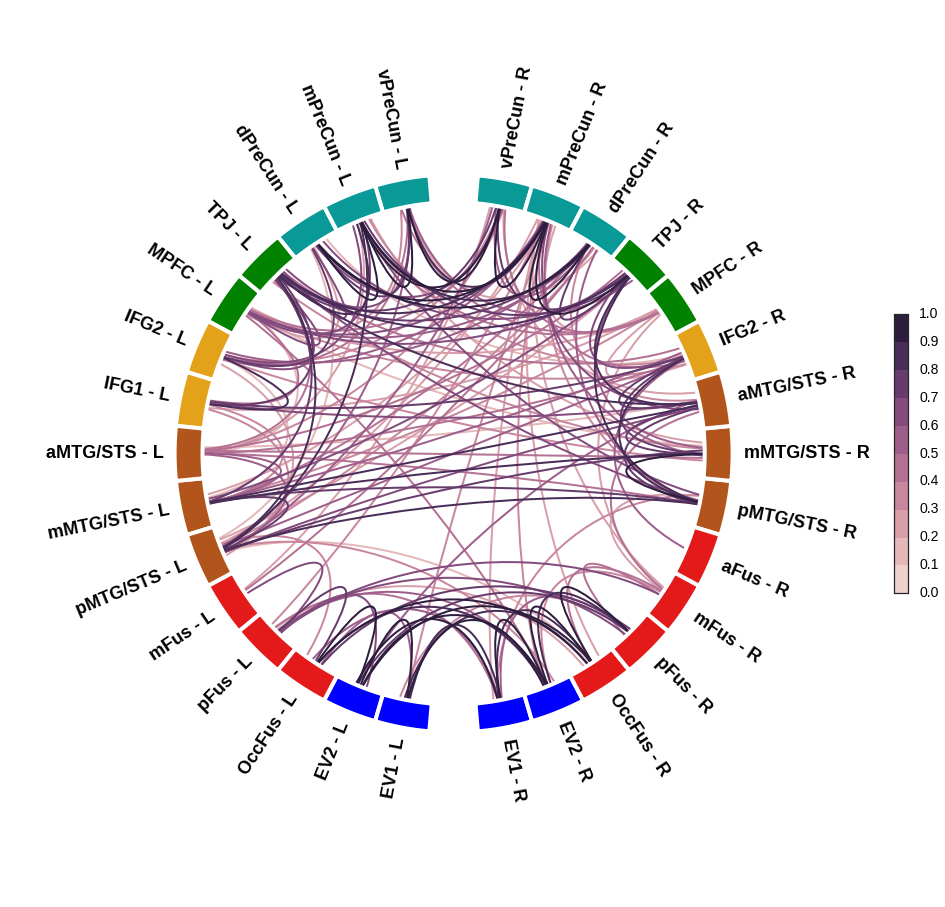

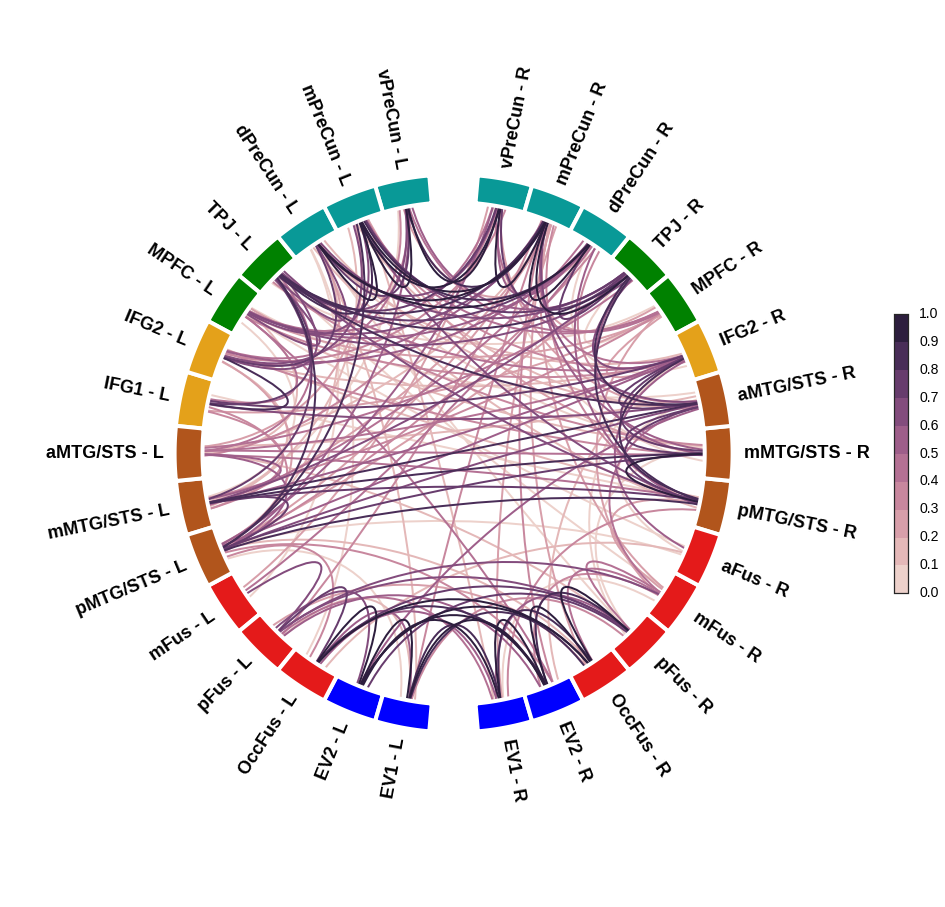

In [73]:
save_figure = False
for i, nlines in enumerate(plot_n_corr):
    fig = plt.figure(figsize=(20, 20), facecolor='white');
    colorbar = True
    f, ax = plot_connectivity_circle(adj_rank, labels, n_lines=nlines,
                                     fig=fig, **connectivity_common_kwargs);
    for t in ax.texts:
        t.set_weight('bold')

    if save_figure:
        fig.savefig('chord_diagram/chord_diagram_top{0:03d}_wh.png'.format(nlines), 
                    dpi=300, facecolor='white', edgecolor='white')
        plt.close()